#### Importing required libraries####


In [532]:
import pandas as pd
import numpy as np

from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn import decomposition
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import graphviz
%matplotlib inline


#### Dataset Load ####

In [533]:
data = pd.read_excel('Combined data_province and age.xlsx')
data.head()

Country     Province Age Group  Age  BirthYear  Gender  \
0  Ivory Coast (Cote D'Ivoire)  Gôh-Djiboua     15-25   24       1995    Male   
1  Ivory Coast (Cote D'Ivoire)    Montagnes     15-25   21       1998  Female   
2  Ivory Coast (Cote D'Ivoire)      Abidjan       36+   50       1969    Male   
3  Ivory Coast (Cote D'Ivoire)      Abidjan     26-35   33       1986  Female   
4  Ivory Coast (Cote D'Ivoire)    Montagnes     15-25   19       2000    Male   

  EmploymentType JobType InformalWorker       Informal Work Type  ...  \
0        Student     NaN            NaN                      NaN  ...   
1  Self-employed     NaN            Yes  Hair/Skin/Nail services  ...   
2          Other     NaN            NaN                      NaN  ...   
3  Self-employed     NaN            Yes  Hair/Skin/Nail services  ...   
4          Other     NaN            NaN                      NaN  ...   

  AidSource_Charities/ Donations AidSource_Friends/family  \
0                            NaN                      NaN   
1                            NaN                      NaN   
2                            NaN                      NaN   
3                            NaN                      NaN   
4                            NaN                      NaN   

  AidSource_Government AidSource_Not sure  AidSource_Other  \
0                  NaN                NaN              NaN   
1                  NaN                NaN              NaN   
2                  NaN                NaN              NaN   
3                  NaN                NaN              NaN   
4                  NaN                NaN              NaN   

  AidSource_Religious Organizations COVIDLoans MobileMoneyActivity  \
0                               NaN         No           Decreased   
1                               NaN        Yes          Don’t know   
2                               NaN        Yes     Stayed the same   
3                               NaN        Yes           Increased   
4                               NaN        Yes     Stayed the same   

  MobileMoneyDeposit               GovernmentPriority  
0                Yes  Protecting people from COVID-19  
1                Yes            Reopening the economy  
2                 No  Protecting people from COVID-19  
3                Yes            Reopening the economy  
4                 No  Protecting people from COVID-19  

[5 rows x 36 columns]

#### Data View - type and null value check #####

In [534]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country                            2500 non-null   object 
 1   Province                           2500 non-null   object 
 2   Age Group                          2500 non-null   object 
 3   Age                                2500 non-null   int64  
 4   BirthYear                          2500 non-null   int64  
 5   Gender                             2500 non-null   object 
 6   EmploymentType                     2500 non-null   object 
 7   JobType                            836 non-null    object 
 8   InformalWorker                     1227 non-null   object 
 9   Informal Work Type                 642 non-null    object 
 10  OtherJob                           417 non-null    object 
 11  JobLoss                            1288 non-null   objec

In [535]:
data.isnull().sum()

Country                                 0
Province                                0
Age Group                               0
Age                                     0
BirthYear                               0
Gender                                  0
EmploymentType                          0
JobType                              1664
InformalWorker                       1273
Informal Work Type                   1858
OtherJob                             2083
JobLoss                              1212
JobRegain                            1737
MonthlyIncome                        1212
MonthlyIncome Bracket                1218
IncomeChange                         1213
ExpenseResponsibility                   0
LengthSurvival                        600
MoneyForExpenses                      600
ConcernExpenses                       600
Expense Concern Rating                600
MonthlyNeed                           568
TopPriority                           532
LowPriority                       

#### Data Transformation and Missing Data Handling ####

In [536]:
#Convert to string the MonthlyNeed column for handling the pipes
data["MonthlyNeed"]= data["MonthlyNeed"].astype(str) 
#By stringsplit get the first bucket where there are multiple pipes for further use as some values are encoded differently
data['MonthlyNeed']=data["MonthlyNeed"].apply(lambda x: x.split("|")[0] if '|' in x else x)
#checking the values for this column 
data.iloc[:,21]
#Getting the unique values 
data.MonthlyNeed.unique()


array(['nan', '150001 - 300000', '0-150000', '500001 - 1000000',
       '300001 - 500000', 'Over 1000000', '0-10000', '20001-50000',
       '100001-200000', '10001-20000', '50001-100000', 'Over 200000',
       '45001- 100000', '100001 - 200000', '0-15000', '15001 - 30000',
       '30001- 45000', 'Over 500001', '0-100000', '300001 - 400000',
       '200001-300000', '400001- 500000', '0-5000', '5001-10000',
       '20001-40000', '60001+', '40001-60000'], dtype=object)

In [537]:
#Questionarrie bucket for MonthlyNeed in the survey 
#1)0-10000
##2)10001-20000
#3)20001-50000
#4)50001-100000
#5)100001-200000
#6)Over 200000

# Transform and Replace the incorrect buckets aligned to the ansers in the questtionarrie
#replacing nan with the bucket 0-10000 -first bucket in questionarrie
data.loc[(data['MonthlyNeed'] == 'nan') ,'MonthlyNeed'] = '0-10000'
#data.MonthlyNeed.unique()
#replacing Over 1000000, Over 500001, 60001+ with correct bucket as per the questionarie buckets
data.loc[(data['MonthlyNeed'] == 'Over 1000000') ,'MonthlyNeed'] = 'Over 200000'

data.loc[(data['MonthlyNeed'] == 'Over 500001') ,'MonthlyNeed'] = 'Over 200000'
data.loc[(data['MonthlyNeed'] == '60001+') ,'MonthlyNeed'] = '50001-100000'
data.MonthlyNeed.unique()

array(['0-10000', '150001 - 300000', '0-150000', '500001 - 1000000',
       '300001 - 500000', 'Over 200000', '20001-50000', '100001-200000',
       '10001-20000', '50001-100000', '45001- 100000', '100001 - 200000',
       '0-15000', '15001 - 30000', '30001- 45000', '0-100000',
       '300001 - 400000', '200001-300000', '400001- 500000', '0-5000',
       '5001-10000', '20001-40000', '40001-60000'], dtype=object)

In [538]:
#As we see from unique values , the vales are different than the questionarri bucket ,to change the value with the correct bucket 
#function monthneedencode which will correctly map the values will be used on MonthlyNeed column
def monthneedencode(monthneed):
    if 'Over' in monthneed:
        value = monthneed
    #convert the value to int for comparison purpose 
    else:
        lowerValue = int(monthneed.split("-")[0])
        upperValue = int(monthneed.split("-")[1])
        if lowerValue == 0 and upperValue <= 10000:
            value = '0-10000'
        elif lowerValue >= 10001 and upperValue <= 20000:
            value = '10001-20000'
        elif lowerValue >=20001 and upperValue <= 50000:
            value = '20001-50000'
        elif lowerValue >=50001 and upperValue <= 50000:
            value = '50001-100000'
        elif lowerValue >=100001 and upperValue <= 200000:
            value = '100001-200000'
        else:
            value = 'Over 200000'
    return value
        
#apply function     
data['MonthlyNeed'] = data['MonthlyNeed'].apply(monthneedencode)
#data.MonthlyNeed.unique()

#check the count for each bucket 
data.groupby("MonthlyNeed")["MonthlyNeed"].count()
#final null value check 
#data.MonthlyNeed.isnull().sum()


MonthlyNeed
0-10000           889
100001-200000     120
10001-20000       186
20001-50000       122
Over 200000      1183
Name: MonthlyNeed, dtype: int64

In [539]:
#For JobType column corresponding to EmploymentType = Unemployed -substituting with meaningful value 
data.loc[data['EmploymentType'] == 'Unemployed','JobType']

5       NaN
6       NaN
12      NaN
18      NaN
20      NaN
       ... 
2485    NaN
2488    NaN
2489    NaN
2492    NaN
2498    NaN
Name: JobType, Length: 741, dtype: object

In [540]:
#Replacing this NaN with Not Working'

data.loc[data['EmploymentType'] == 'Unemployed','JobType'] ='Not Working'

In [541]:
#Verifying the replacement 
data.loc[data['EmploymentType'] == 'Unemployed','JobType']

5       Not Working
6       Not Working
12      Not Working
18      Not Working
20      Not Working
           ...     
2485    Not Working
2488    Not Working
2489    Not Working
2492    Not Working
2498    Not Working
Name: JobType, Length: 741, dtype: object

In [542]:
#Change Job Type column values for the corresponding employment type = student with meaningful represenatation
data.loc[data['EmploymentType'] == 'Student','JobType']

0       NaN
8       NaN
9       NaN
11      NaN
19      NaN
       ... 
2484    NaN
2486    NaN
2490    NaN
2493    NaN
2497    NaN
Name: JobType, Length: 473, dtype: object

In [543]:
data.loc[data['EmploymentType'] == 'Student','JobType'] = 'Student'

In [544]:
#Checking all the unique columns for Job Type
data.loc[data['EmploymentType'] == 'Student','JobType']
data['EmploymentType'].isnull().sum()
data.JobType.unique()

array(['Student', nan, 'Not Working', 'Other',
       'Small business owner/employee', 'Educator', 'Healthcare',
       'Large business', 'Government'], dtype=object)

In [545]:
#Fill the NA values of MonthlyIncome bucket with the first bucket as it covers the 0 value as well
data['MonthlyIncome'].isnull().sum()
data["MonthlyIncome"].fillna('0-15000', inplace = True)  

In [546]:
data['MonthlyIncome'].isnull().values.any()


False

In [547]:
data.loc[data['EmploymentType'] == 'Unemployed', 'MonthlyIncome']


5       0-15000
6       0-15000
12      0-15000
18      0-15000
20      0-15000
         ...   
2485    0-15000
2488    0-15000
2489    0-15000
2492    0-15000
2498    0-15000
Name: MonthlyIncome, Length: 741, dtype: object

In [548]:
data['MonthlyIncome Bracket'].isnull().sum()

1218

In [549]:
#Fill the NA values of MonthlyIncome bucket to 1 as that coveres 0 value as well in the income range
data["MonthlyIncome Bracket"].fillna(1, inplace = True)  

In [550]:
data['MonthlyIncome Bracket'].isnull().sum()

0

In [551]:
data['JobType'].isnull().sum()

451

In [552]:
#Replace the Jobtype column values for the corresponding EmploymentType = Self-employed to meaningful representation
data.loc[data['EmploymentType'] == 'Self-employed','JobType'] ='Self-employed'

In [553]:
data['JobType'].isnull().sum()

89

In [554]:
#Change the column values of JobType to other corresponding to employment type = Other value
data.loc[data['EmploymentType'] == 'Other','JobType'] ='Other'

In [555]:
data['JobType'].isnull().sum()

0

In [556]:
data['JobLoss'].isnull().sum()

1212

In [557]:
#Fill the NA values of JobLoss column to Not applicable treating them as individual level- as we have observed the most of this NA value correspond to student or unemployed
data["JobLoss"].fillna('Not Applicable', inplace = True)

In [558]:
data['JobLoss'].isnull().sum()

0

In [559]:
data['JobRegain'].isnull().sum()

1737

In [560]:
#Fill the NA values of JobRegain column to Not applicable treating them as individual level- as we have observed the most of this NA value correspond to student or unemployed
data["JobRegain"].fillna('Not Applicable', inplace = True)

In [561]:
data['JobRegain'].isnull().sum()

0

In [562]:
data['MonthlyIncome Bracket'].isnull().sum()

0

In [563]:
data.LengthSurvival.unique()

array([nan, '< a month', '2-4 months', 'Don’t know', '5+ months',
       '1 month', "Don't know"], dtype=object)

In [564]:
#As LengthSurvival column has the simlar information of Don't know in two labels and we observed that it is just because of the 
#difference of comma and single quotation, we will change both these labels to  uniform one Donot know to address these issue  as both labels represent same information
data.loc[(data['LengthSurvival'] == "Don't know") | (data['LengthSurvival'] =='Don’t know'),'LengthSurvival'] = 'Donot know'
         

In [565]:
data.loc[(data['LengthSurvival'] == "Donot know") ,'LengthSurvival']

4       Donot know
6       Donot know
10      Donot know
15      Donot know
19      Donot know
           ...    
2479    Donot know
2481    Donot know
2484    Donot know
2494    Donot know
2496    Donot know
Name: LengthSurvival, Length: 420, dtype: object

In [566]:
data['LengthSurvival'].isnull().sum()

600

In [567]:
#Fill the NA values of LengthSurvivalas Not Applicable treating them as separate category 
data["LengthSurvival"].fillna('Not Applicable', inplace = True)

In [568]:
data['LengthSurvival'].isnull().sum()

0

In [569]:
data['IncomeChange'].isnull().sum()

1213

In [570]:
#Fill the NA values of IncomeChange as Not Applicable treating them as separate category because for students and unempoyed it does not matter 
data["IncomeChange"].fillna('Not Applicable', inplace = True)

In [571]:
data['IncomeChange'].isnull().sum()

0

In [572]:
#Fill the NA values of MoneyForExpenses as Not Applicable 
data['MoneyForExpenses'].isnull().sum()
data["MoneyForExpenses"].fillna('Not Applicable', inplace = True)

In [573]:
data['AidSource_Aid Organisations'].isnull().sum()

2081

In [574]:
#Fill the NA values for the different AIDS to Not Applicable as the AID column does not have missing value and these individual colmns just represent which particular type of AID has been recieved in case of Yes for AID and therefore other types will not be responsible.

data.fillna({'AidSource_Aid Organisations':'Not Applicable', 'AidSource_Charities/ Donations':'Not Applicable','AidSource_Friends/family':'Not Applicable',
            'AidSource_Government':'Not Applicable','AidSource_Not sure':'Not Applicable',
             'AidSource_Other':'Not Applicable','AidSource_Religious Organizations':'Not Applicable'}, inplace=True)

In [575]:
data['AidSource_Aid Organisations'].isnull().sum()
data['AidSource_Aid Organisations'].unique()

#data.loc[(data['AidSource_Aid Organisations']== '')]

array(['Not Applicable', 'Yes', 'No'], dtype=object)

In [576]:
data.MobileMoneyActivity.unique()

array(['Decreased', 'Don’t know', 'Stayed the same', 'Increased',
       "Don't know"], dtype=object)

In [577]:
#Replace the two level of MobileMoneyActivity to uniform level as these are data entry error and because of comma and column divide into two labels but they mean the same label - donot know 

data.loc[(data['MobileMoneyActivity'] == "Don't know") | (data['MobileMoneyActivity'] =='Don’t know'),'MobileMoneyActivity'] = 'Donot know'

In [578]:
data.loc[(data['MobileMoneyActivity'] == "Donot know") ,'MobileMoneyActivity']

1       Donot know
20      Donot know
25      Donot know
31      Donot know
34      Donot know
           ...    
2441    Donot know
2452    Donot know
2455    Donot know
2470    Donot know
2484    Donot know
Name: MobileMoneyActivity, Length: 224, dtype: object

In [579]:
data['ConcernExpenses'].isnull().sum()

600

In [580]:
#fill NA values with Not Applicable category as separate level
data["ConcernExpenses"].fillna('Not Applicable', inplace = True)

In [581]:
data['ConcernExpenses'].isnull().sum()

0

In [582]:
data.ConcernExpenses.unique()

array(['Not Applicable', 'No change', 'More concerned', 'Less concerned'],
      dtype=object)

In [583]:
data['Expense Concern Rating'].isnull().sum()

600

In [584]:
data["Expense Concern Rating"].fillna(1, inplace = True)

In [585]:
data['Expense Concern Rating'].isnull().sum()

0

In [586]:
data['Expense Concern Rating'].unique()

array([1. , 5. , 3. , 2. , 4. , 1.4])

In [587]:
data.loc[(data['Expense Concern Rating'] == 1.4) ,'Expense Concern Rating'] = 1

In [588]:
data['Expense Concern Rating'].unique()

array([1., 5., 3., 2., 4.])

In [589]:
#Copy the data to new dataframe and drop the coulumns we are not considering for further use
newdata = data.copy()

In [590]:
newdata1 = newdata.drop(['Country','Province','Age Group','BirthYear','JobType','InformalWorker','Informal Work Type',
                        'OtherJob','MonthlyIncome','TopPriority','LowPriority','AidSource_Aid Organisations','AidSource_Charities/ Donations',
                        'AidSource_Friends/family','AidSource_Government','AidSource_Not sure','AidSource_Other','AidSource_Religious Organizations',
                        ], axis = 1)

In [591]:
newdata1.head()
newdata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     2500 non-null   int64  
 1   Gender                  2500 non-null   object 
 2   EmploymentType          2500 non-null   object 
 3   JobLoss                 2500 non-null   object 
 4   JobRegain               2500 non-null   object 
 5   MonthlyIncome Bracket   2500 non-null   float64
 6   IncomeChange            2500 non-null   object 
 7   ExpenseResponsibility   2500 non-null   object 
 8   LengthSurvival          2500 non-null   object 
 9   MoneyForExpenses        2500 non-null   object 
 10  ConcernExpenses         2500 non-null   object 
 11  Expense Concern Rating  2500 non-null   float64
 12  MonthlyNeed             2500 non-null   object 
 13  Aid                     2500 non-null   object 
 14  COVIDLoans              2500 non-null   

In [592]:
#Map the rating with their corresponsponding bucket
concernratingmap = {1: 'Not Concerned at all', 2: 'Less concerned',3:'Concerned', 4:'More concerned', 5:'Extremely concerned' }
newdata1['Expense Concern Rating'] = newdata1['Expense Concern Rating'].map(concernratingmap)


#### Supervised Learning ####


In [593]:
#split data into x and y to build the model
y = newdata1['Expense Concern Rating']
x = newdata1.drop('Expense Concern Rating', axis = 1)

In [594]:
#splitting data

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state = 50)

In [595]:
#extracting object type columns for conversion
features_to_encode = list(X_train.select_dtypes(include = ['object']).columns) 

In [596]:
#create constructor handle for categorical featureswhichwill automatically handle the categorical variables and leave numeric variables 
column_transform = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

First Decision Tree Classifier using Pipeline 

In [597]:
decisiontree_classifier = Pipeline(steps=[('preprocessor', column_transform),
                      ('classifier', DecisionTreeClassifier(min_samples_split=100))])

In [598]:
decisiontree_classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Gender', 'EmploymentType',
                                                   'JobLoss', 'JobRegain',
                                                   'IncomeChange',
                                               

In [599]:
#Pipeline created with a constructor to handle inputs with categorical variables and transform them and with a classifier that receives the transformed values and build a Decision tree.
y_pred = decisiontree_classifier.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"Accuracy using DecisionTree is {round(accuracy_score(y_test,y_pred),3)*100} %")
#print("model score: %.3f" % decisiontree_classifier.score(X_train, y_train))




Accuracy using DecisionTree is 68.5 %


#### Decision Tree - without Pipeline to handle the transformation of the variables ####

In [600]:
#Instead of using Pipeline to deal with the transfor of variables, here we have separately transformed them to use for classifier
#Create new dataframe with the clean data to build the Classifier

classifier_data = newdata1.copy()
classifier_data.head()
#classifier_data.ConcernExpenses.unique()

Age  Gender EmploymentType                    JobLoss       JobRegain  \
0   24    Male        Student             Not Applicable  Not Applicable   
1   21  Female  Self-employed                        Yes             Yes   
2   50    Male          Other  No-I’m still able to work  Not Applicable   
3   33  Female  Self-employed                        Yes             Yes   
4   19    Male          Other  No-I’m still able to work  Not Applicable   

   MonthlyIncome Bracket     IncomeChange ExpenseResponsibility  \
0                    1.0   Not Applicable                    No   
1                    1.0  Decreased a lot                    No   
2                    1.0  Decreased a bit                   Yes   
3                    2.0  Decreased a lot                   Yes   
4                    1.0        No change                   Yes   

   LengthSurvival MoneyForExpenses ConcernExpenses Expense Concern Rating  \
0  Not Applicable   Not Applicable  Not Applicable   Not Concerned at all   
1  Not Applicable   Not Applicable  Not Applicable   Not Concerned at all   
2       < a month            Other       No change    Extremely concerned   
3      2-4 months          Savings  More concerned              Concerned   
4      Donot know          Savings       No change   Not Concerned at all   

   MonthlyNeed Aid COVIDLoans MobileMoneyActivity MobileMoneyDeposit  \
0      0-10000  No         No           Decreased                Yes   
1      0-10000  No        Yes          Donot know                Yes   
2  Over 200000  No        Yes     Stayed the same                 No   
3  Over 200000  No        Yes           Increased                Yes   
4  Over 200000  No        Yes     Stayed the same                 No   

                GovernmentPriority  
0  Protecting people from COVID-19  
1            Reopening the economy  
2  Protecting people from COVID-19  
3            Reopening the economy  
4  Protecting people from COVID-19

Data transformation for model building 

In [601]:
#Convert the category of concern expense to numerical inputs in order to use them in the model input


classifier_data['ConcernExpenses'] = classifier_data['ConcernExpenses'].map({'No change': 0,'Less concerned':1,'More concerned':2,'Not Applicable':3})
#classifier_data.head(10)
classifier_data['ConcernExpenses'].value_counts()


2    1337
3     600
1     340
0     223
Name: ConcernExpenses, dtype: int64

In [602]:
classifier_data['ConcernExpenses'].unique()


array([3, 0, 2, 1], dtype=int64)

In [603]:
classifier_data.MonthlyNeed.unique()

array(['0-10000', 'Over 200000', '20001-50000', '100001-200000',
       '10001-20000'], dtype=object)

In [604]:
#changing monthlyneed categorical to integer and consider the bins we have got in the questionarrie

monthlyneedmap = {'0-10000': 1,'10001-20000' :2 ,'20001-50000' :3, '50001-100000' :4, '100001-200000':5, 'Over 200000':6 }
classifier_data['MonthlyNeed'] = classifier_data['MonthlyNeed'].map(monthlyneedmap)

In [605]:
classifier_data['MonthlyNeed'].value_counts()

6    1183
1     889
2     186
3     122
5     120
Name: MonthlyNeed, dtype: int64

In [606]:
classifier_data.MonthlyNeed.unique()

array([1, 6, 3, 5, 2], dtype=int64)

In [607]:
classifier_data['Expense Concern Rating'].unique()

array(['Not Concerned at all', 'Extremely concerned', 'Concerned',
       'Less concerned', 'More concerned'], dtype=object)

In [608]:
#Change the concernrating value to integer to use in teh model
concernratingmap = {'Not Concerned at all': 1, 'Less concerned':2,'Concerned':3, 'More concerned':4, 'Extremely concerned':5}
classifier_data['Expense Concern Rating'] = classifier_data['Expense Concern Rating'].map(concernratingmap)

In [609]:
classifier_data['Expense Concern Rating'].value_counts()

5    1179
1     891
3     186
4     147
2      97
Name: Expense Concern Rating, dtype: int64

In [610]:
classifier_data['Expense Concern Rating'].unique()

array([1, 5, 3, 2, 4], dtype=int64)

In [611]:
#Converting other categorical variabels ('object type') to dummy variables
classifier_data.info()
columnlist = ['Gender','EmploymentType','JobLoss','JobRegain','IncomeChange','ExpenseResponsibility',
              'LengthSurvival','MoneyForExpenses','Aid','COVIDLoans','MobileMoneyActivity','MobileMoneyDeposit','GovernmentPriority']
#using drop_first = True will generate k-1 dummies out of k categorical levels by removing the first level to remove multicollinearity

classifierdata_dummies = pd.get_dummies(classifier_data, columns=columnlist,drop_first = False)

print ("Column Names: ", classifierdata_dummies.columns.tolist())
print ("\n")
print ("Total No of Columns: ", len(classifierdata_dummies.columns.tolist()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     2500 non-null   int64  
 1   Gender                  2500 non-null   object 
 2   EmploymentType          2500 non-null   object 
 3   JobLoss                 2500 non-null   object 
 4   JobRegain               2500 non-null   object 
 5   MonthlyIncome Bracket   2500 non-null   float64
 6   IncomeChange            2500 non-null   object 
 7   ExpenseResponsibility   2500 non-null   object 
 8   LengthSurvival          2500 non-null   object 
 9   MoneyForExpenses        2500 non-null   object 
 10  ConcernExpenses         2500 non-null   int64  
 11  Expense Concern Rating  2500 non-null   int64  
 12  MonthlyNeed             2500 non-null   int64  
 13  Aid                     2500 non-null   object 
 14  COVIDLoans              2500 non-null   

In [612]:
#New dataframe after transformation the categorical variables
classifierdata_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 54 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Age                                                 2500 non-null   int64  
 1   MonthlyIncome Bracket                               2500 non-null   float64
 2   ConcernExpenses                                     2500 non-null   int64  
 3   Expense Concern Rating                              2500 non-null   int64  
 4   MonthlyNeed                                         2500 non-null   int64  
 5   Gender_Female                                       2500 non-null   uint8  
 6   Gender_Male                                         2500 non-null   uint8  
 7   EmploymentType_Employed full time                   2500 non-null   uint8  
 8   EmploymentType_Employed part time                   2500 non-null   uint8  
 9

In [613]:
#dividing dataframe to features - independent variables and label- predcted variable for classification
labels = classifierdata_dummies[['Expense Concern Rating']]
features = classifierdata_dummies.drop(['Expense Concern Rating'], axis=1)


In [614]:
list_columns = list(features.columns.values)
#col_names_list
#Separate Train and Test Data

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state =0)
print ("No of Training Samples: ", len(X_train))
print ("No of Test Samples: ", len(X_test))

No of Training Samples:  1675
No of Test Samples:  825


Build the Decision Tree Classifier and check the accuracy 

In [615]:
deisiontree_clf = DecisionTreeClassifier(criterion = 'entropy',max_depth=5, min_samples_split=100, random_state = 1)
deisiontree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [616]:
y_pred = deisiontree_clf.predict(X_test)
#accuracy
#accuracy_score(y_test, y_pred)
print("Accuracy using DecisionTree is %.3f" % accuracy_score(y_test,y_pred))
#print("model score on train data: %.3f" % deisiontree_clf.score(X_train, y_train))
print("####### ConfusionMatrix ########")
print("\n")
print(confusion_matrix(y_test, y_pred))



Accuracy using DecisionTree is 0.707
####### ConfusionMatrix ########


[[205   0   0   0  99]
 [  1   0   2   0  31]
 [  3   0   3   0  55]
 [  0   0   0   0  41]
 [  6   0   4   0 375]]


View the Decision Tree

In [617]:
#Decision Tree Diagram

class_names = ['1','2', '3','4','5']
#list_columns = list(features.columns.values)
dot_data = tree.export_graphviz(deisiontree_clf, out_file=None, filled=True, rounded=True,
                                feature_names=list_columns,  
                                class_names=class_names)
graph = graphviz.Source(dot_data,filename="Output_DecisionTree.gv", format="png") 
graph.view()



'Output_DecisionTree.gv.png'

Tuning the Hyperparameters of Decision Tree

Text(0, 0.5, 'Accuracy Score')

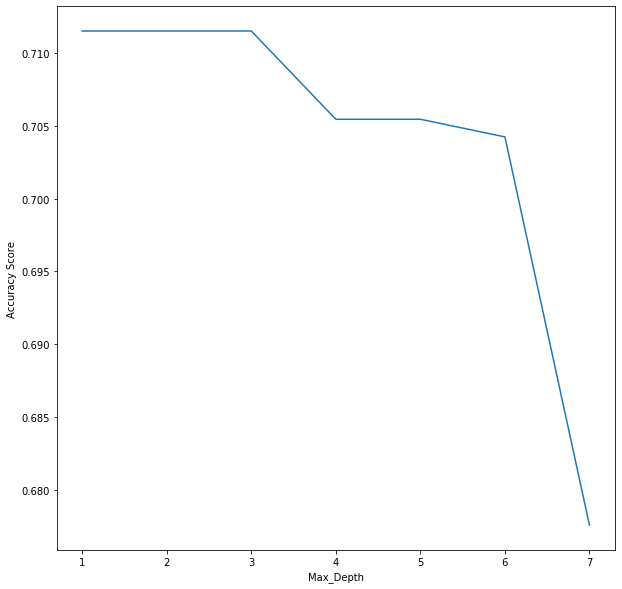

In [618]:
#Tuning the deapth of tree 

range_maxdepth = list(range(1, 8))
# List to store the average RMSE for each value of max_depth:
accuracy = []
for depth in range_maxdepth:
    
    dect_clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 2)
    dect_clf.fit(X_train, y_train)
    score = dect_clf.score(X_test, y_test)
    accuracy.append(score)

#accuracy
plt.figure(figsize=(10,10))
plt.plot(range_maxdepth, accuracy)
plt.xlabel("Max_Depth")
plt.ylabel("Accuracy Score")


GridSearchCV method for estimating the hyperparameters

In [619]:
#Instead of selecting the hyper parameters of decision tree separately , next we will use gridsearchCV for selecting the best parameters of the model
seed = 30
#dividing dataframe to features - independent variables and label- predcted variable for classification
labels = classifierdata_dummies[['Expense Concern Rating']]
features = classifierdata_dummies.drop(['Expense Concern Rating'], axis=1)

#creating object PCA - principal component analysis extracting features and reducing the dimensionality of the dataset
pca = decomposition.PCA()
#create decision tree 

decisiontree = tree.DecisionTreeClassifier()

#create pipeline of these two steps

pipe = Pipeline(steps=[('pca', pca),
                       ('decisiontree', decisiontree)])

#Listof parameter for decision tree classifier 
maxdepth = np.arange(3,15)
criterion = ['gini','entropy']
# Create a list of a sequence of integers from 1 to number of features in X + 1
                
noofcomponents = list(range(1,classifier_data.shape[1]+1,1))
# Create a dictionary of all the parameter options 
parameters = dict(pca__n_components=noofcomponents,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=maxdepth)

# grid search object creation
gridsearch_clf = GridSearchCV(pipe, parameters)  
# Fit the grid search
gridsearch_clf.fit(X_train,y_train)

#Best Parameters for Decision Tree
print('Best Criterion for Decision Tree:', gridsearch_clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best Max_Depth:', gridsearch_clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best No of Componenets to be considered:', gridsearch_clf.best_estimator_.get_params()['pca__n_components'])
print(gridsearch_clf.best_estimator_.get_params()['decisiontree']) 
 
# Use Cross Validation To Evaluate Model
crossvalidation = cross_val_score(gridsearch_clf, features, labels, cv=5, n_jobs=-1)
print(); print(crossvalidation)



Best Criterion for Decision Tree: entropy
Best Max_Depth: 3
Best No of Componenets to be considered: 16
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[0.638 0.7   0.708 0.736 0.708]


In [620]:
#Using range of values for k-fold cross validation
crossvalidation_range = range(3,10)
for value in crossvalidation_range:
    print("Crossvalidation Score for %d-fold : %3.2f" %(value, gridsearch_clf.score(X_test,y_test)))
    
    

    

Crossvalidation Score for 3-fold : 0.70
Crossvalidation Score for 4-fold : 0.70
Crossvalidation Score for 5-fold : 0.70
Crossvalidation Score for 6-fold : 0.70
Crossvalidation Score for 7-fold : 0.70
Crossvalidation Score for 8-fold : 0.70
Crossvalidation Score for 9-fold : 0.70


Important Features considered in Decision Tree

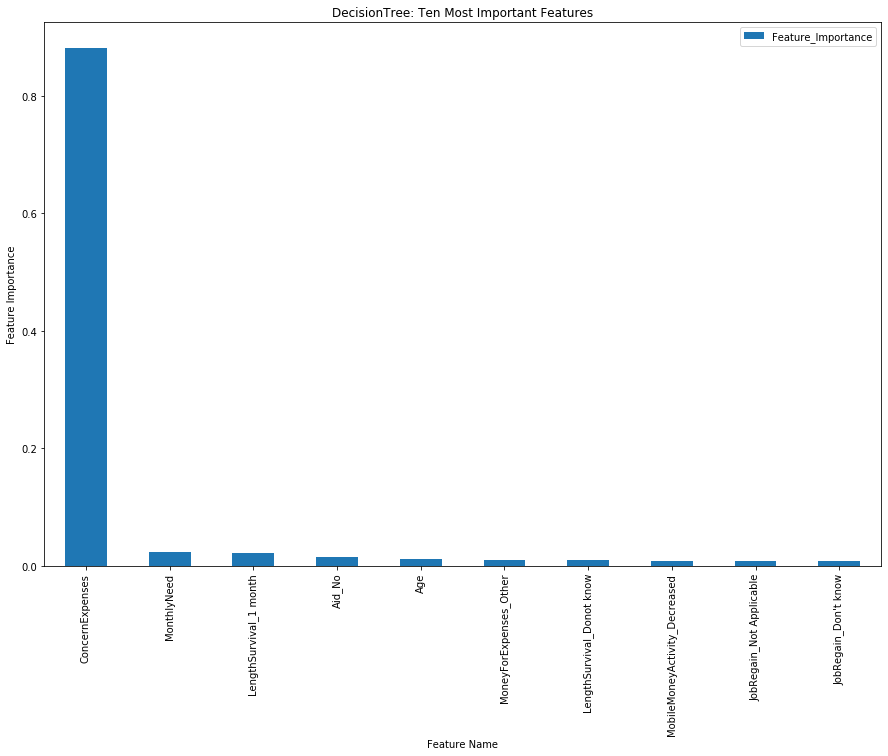

In [621]:
#Feature Importance
from matplotlib import pyplot
feature_importance = pd.DataFrame({'Feature_Name':X_train.columns,
                                   'Feature_Importance':np.round(deisiontree_clf.feature_importances_,4)})
feature_importance = feature_importance.sort_values('Feature_Importance',ascending=False)
feature_importance

fifteen_importantfeatures = feature_importance.head(10)
#twenty_importantfeatures
plt.rcParams["figure.figsize"] = [15,10]
fifteen_importantfeatures.plot.bar(x="Feature_Name", y="Feature_Importance")
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("DecisionTree: Ten Most Important Features")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.show(block=True)


Feature Selection of Decision Tree by SelectModel method

In [622]:
#Try with SelectModel with the initial Decision Tree so that it will take the important features only in consideration
#hyperparameters used here are the estimated best one from GridSEarch in previous step
clf_dectree = DecisionTreeClassifier(random_state = 8, criterion='entropy')
clf_dectree.fit(X_train, y_train.values.ravel())
clfdectree_select = SelectFromModel(clf_dectree)
#Training the selecter
clfdectree_select.fit(X_train, y_train.values.ravel())

featureselect = X_train.columns[(clfdectree_select.get_support())]
featureselect

Index(['Age', 'MonthlyIncome Bracket', 'ConcernExpenses', 'MonthlyNeed',
       'IncomeChange_Decreased a bit', 'ExpenseResponsibility_No',
       'LengthSurvival_5+ months', 'LengthSurvival_< a month', 'COVIDLoans_No',
       'GovernmentPriority_Protecting people from COVID-19'],
      dtype='object')

Train New Decision Tree Classifier with just the selcted important feature

In [623]:
#Selecting only these important features and transfor the training and test set 
Xtrain_newdectree = clfdectree_select.transform(X_train)
Xtest_newdectree = clfdectree_select.transform(X_test)
#new randomforest classifier with these important features
decclf_final = DecisionTreeClassifier(random_state = 40, criterion='entropy')                                       
#Training this new classifier with updated data having the features which are important
decclf_final.fit(Xtrain_newdectree,y_train.values.ravel())    

ypred_finaldecTree = decclf_final.predict(Xtest_newdectree)
# Accuaracy with the model having only the important features from Decision Tree
print("Accuracy with selected important features DecisionTree Classifier: {:.3f}".format(metrics.accuracy_score(y_test, ypred_finaldecTree)))


Accuracy with selected important features DecisionTree Classifier: 0.584


As we can see that we have got less accuarcy score with these selected featuresthough we have reduced the dimensionility

Feature Selection of Decision Tree with Recursive Feature Elimination(RFE) method

In [624]:
#Feature Selection with RFE for Decision tree Classifier
rfe_select = RFE(DecisionTreeClassifier(random_state = 30,criterion='entropy'),n_features_to_select = 16)
rfe_select.fit(X_train, y_train.values.ravel())


RFE(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                     criterion='entropy', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     presort='deprecated', random_state=30,
                                     splitter='best'),
    n_features_to_select=16, step=1, verbose=0)

In [625]:
decstree_RFEfeature = X_train.columns[(rfe_select.get_support())]
decstree_RFEfeature

Index(['Age', 'MonthlyIncome Bracket', 'ConcernExpenses', 'MonthlyNeed',
       'Gender_Female', 'Gender_Male', 'EmploymentType_Employed part time',
       'EmploymentType_Self-employed', 'EmploymentType_Unemployed',
       'JobLoss_No-I’m still able to work', 'LengthSurvival_< a month',
       'MoneyForExpenses_Savings', 'COVIDLoans_Yes',
       'MobileMoneyActivity_Decreased', 'MobileMoneyDeposit_Yes',
       'GovernmentPriority_Protecting people from COVID-19'],
      dtype='object')

Decision Tree Classifier with only the selected features by RFE method

In [626]:
#New subset with the features selected by RFE -Recursive Feature Elimination method
Xtrain_decsrfeselected = rfe_select.transform(X_train)
Xtest_decsrfeselected =rfe_select.transform(X_test)

decstree_rfe = DecisionTreeClassifier(random_state =2,criterion='entropy')                                       
#Training this new classifier with updated data having the features which are important by RFE method
decstree_rfe.fit(Xtrain_decsrfeselected,y_train.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2, splitter='best')

In [627]:
ypred_dectree_rfe = decstree_rfe.predict(Xtest_decsrfeselected)
# Accuaracy with the decision tree model having only the important features
print("Accuracy of Decision TreeClassifier with features selected by Recursive Feature Elimination : {:.3f}".format(metrics.accuracy_score(y_test, ypred_dectree_rfe)))


Accuracy of Decision TreeClassifier with features selected by Recursive Feature Elimination : 0.559


#### Random Forest Classifier ####

In [628]:
#Moving to Random Forest Classifier as decisiontree tends to be overfitting
#Random Forest classifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=10,
                      max_features='auto')
rf_classifier.fit(X_train,y_train.values.ravel())

rf_y_pred=rf_classifier.predict(X_test)
print("Accuracy using DecisionTree is %.3f" % metrics.accuracy_score(y_test, rf_y_pred))

Accuracy using DecisionTree is 0.712


View the first and 50th estimator of Random Forest Tree Classifier

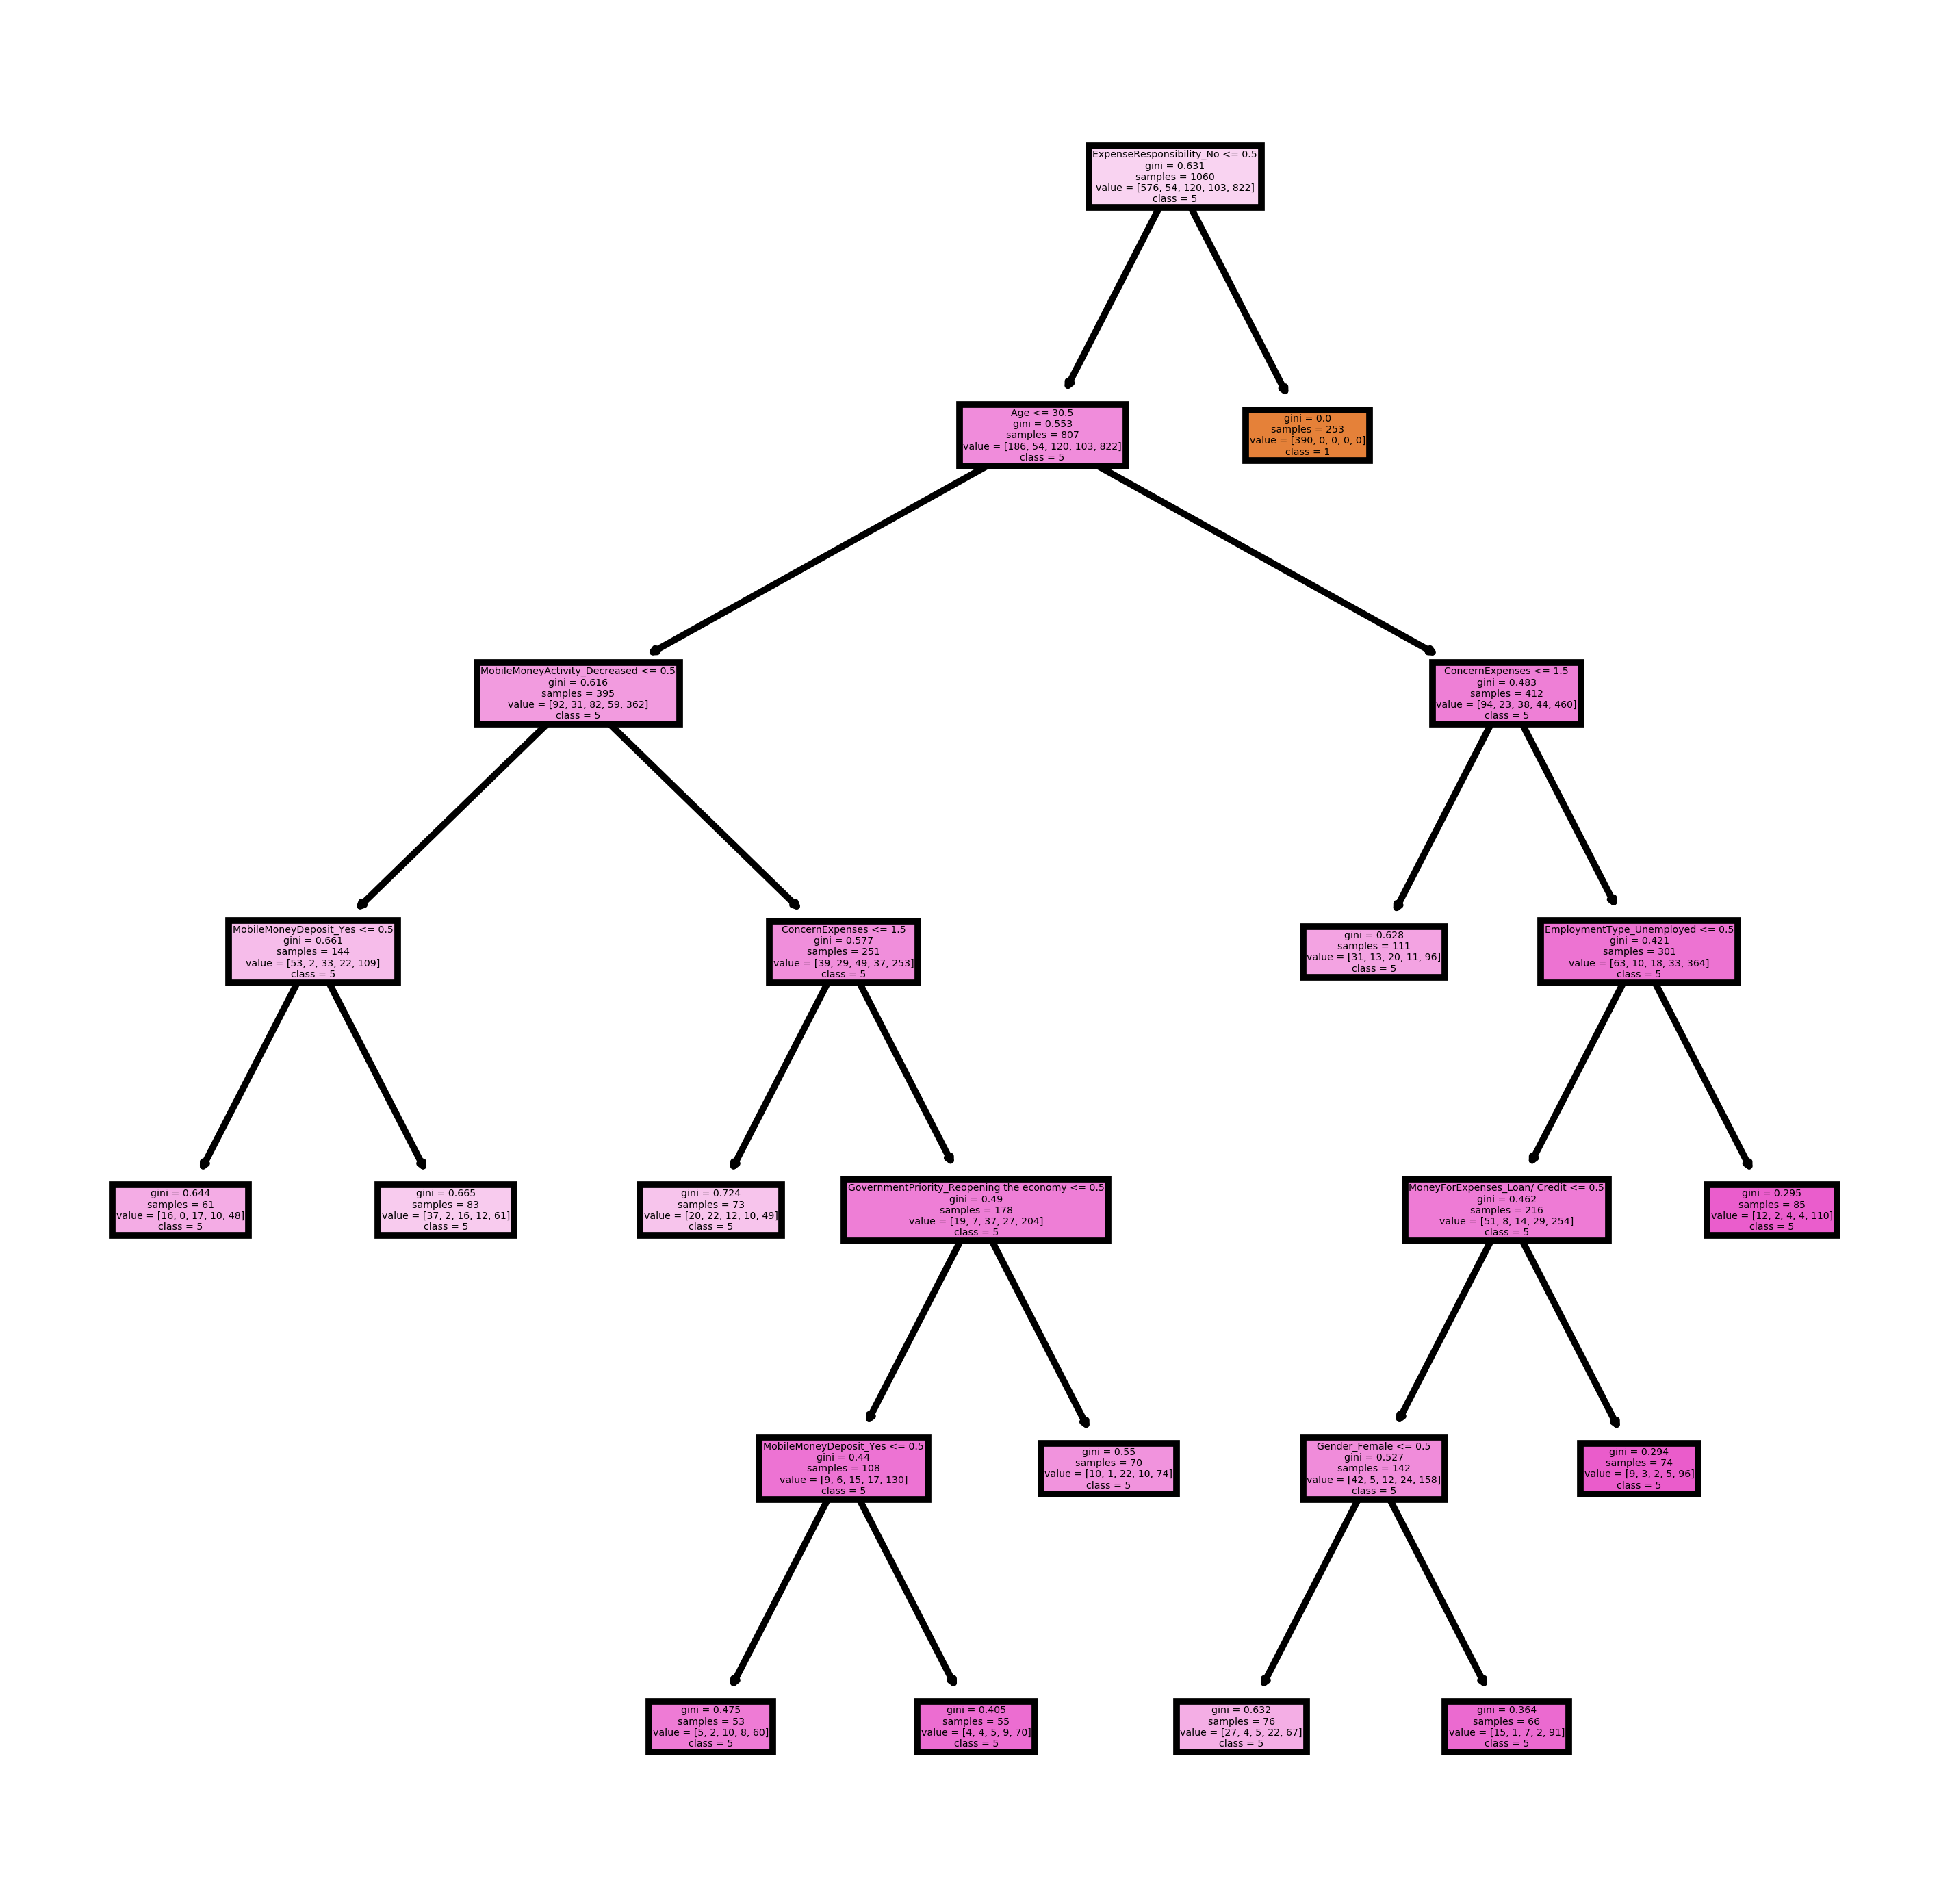

In [629]:
#As there are 150 estimators, we will view the first tree only 
class_names = ['1','2', '3','4','5']
list_columns = list(features.columns.values)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=700)
tree.plot_tree(rf_classifier.estimators_[0],
               feature_names = list_columns, 
               class_names=class_names,
               filled = True);
fig.savefig('randomforestFirstTree.png')

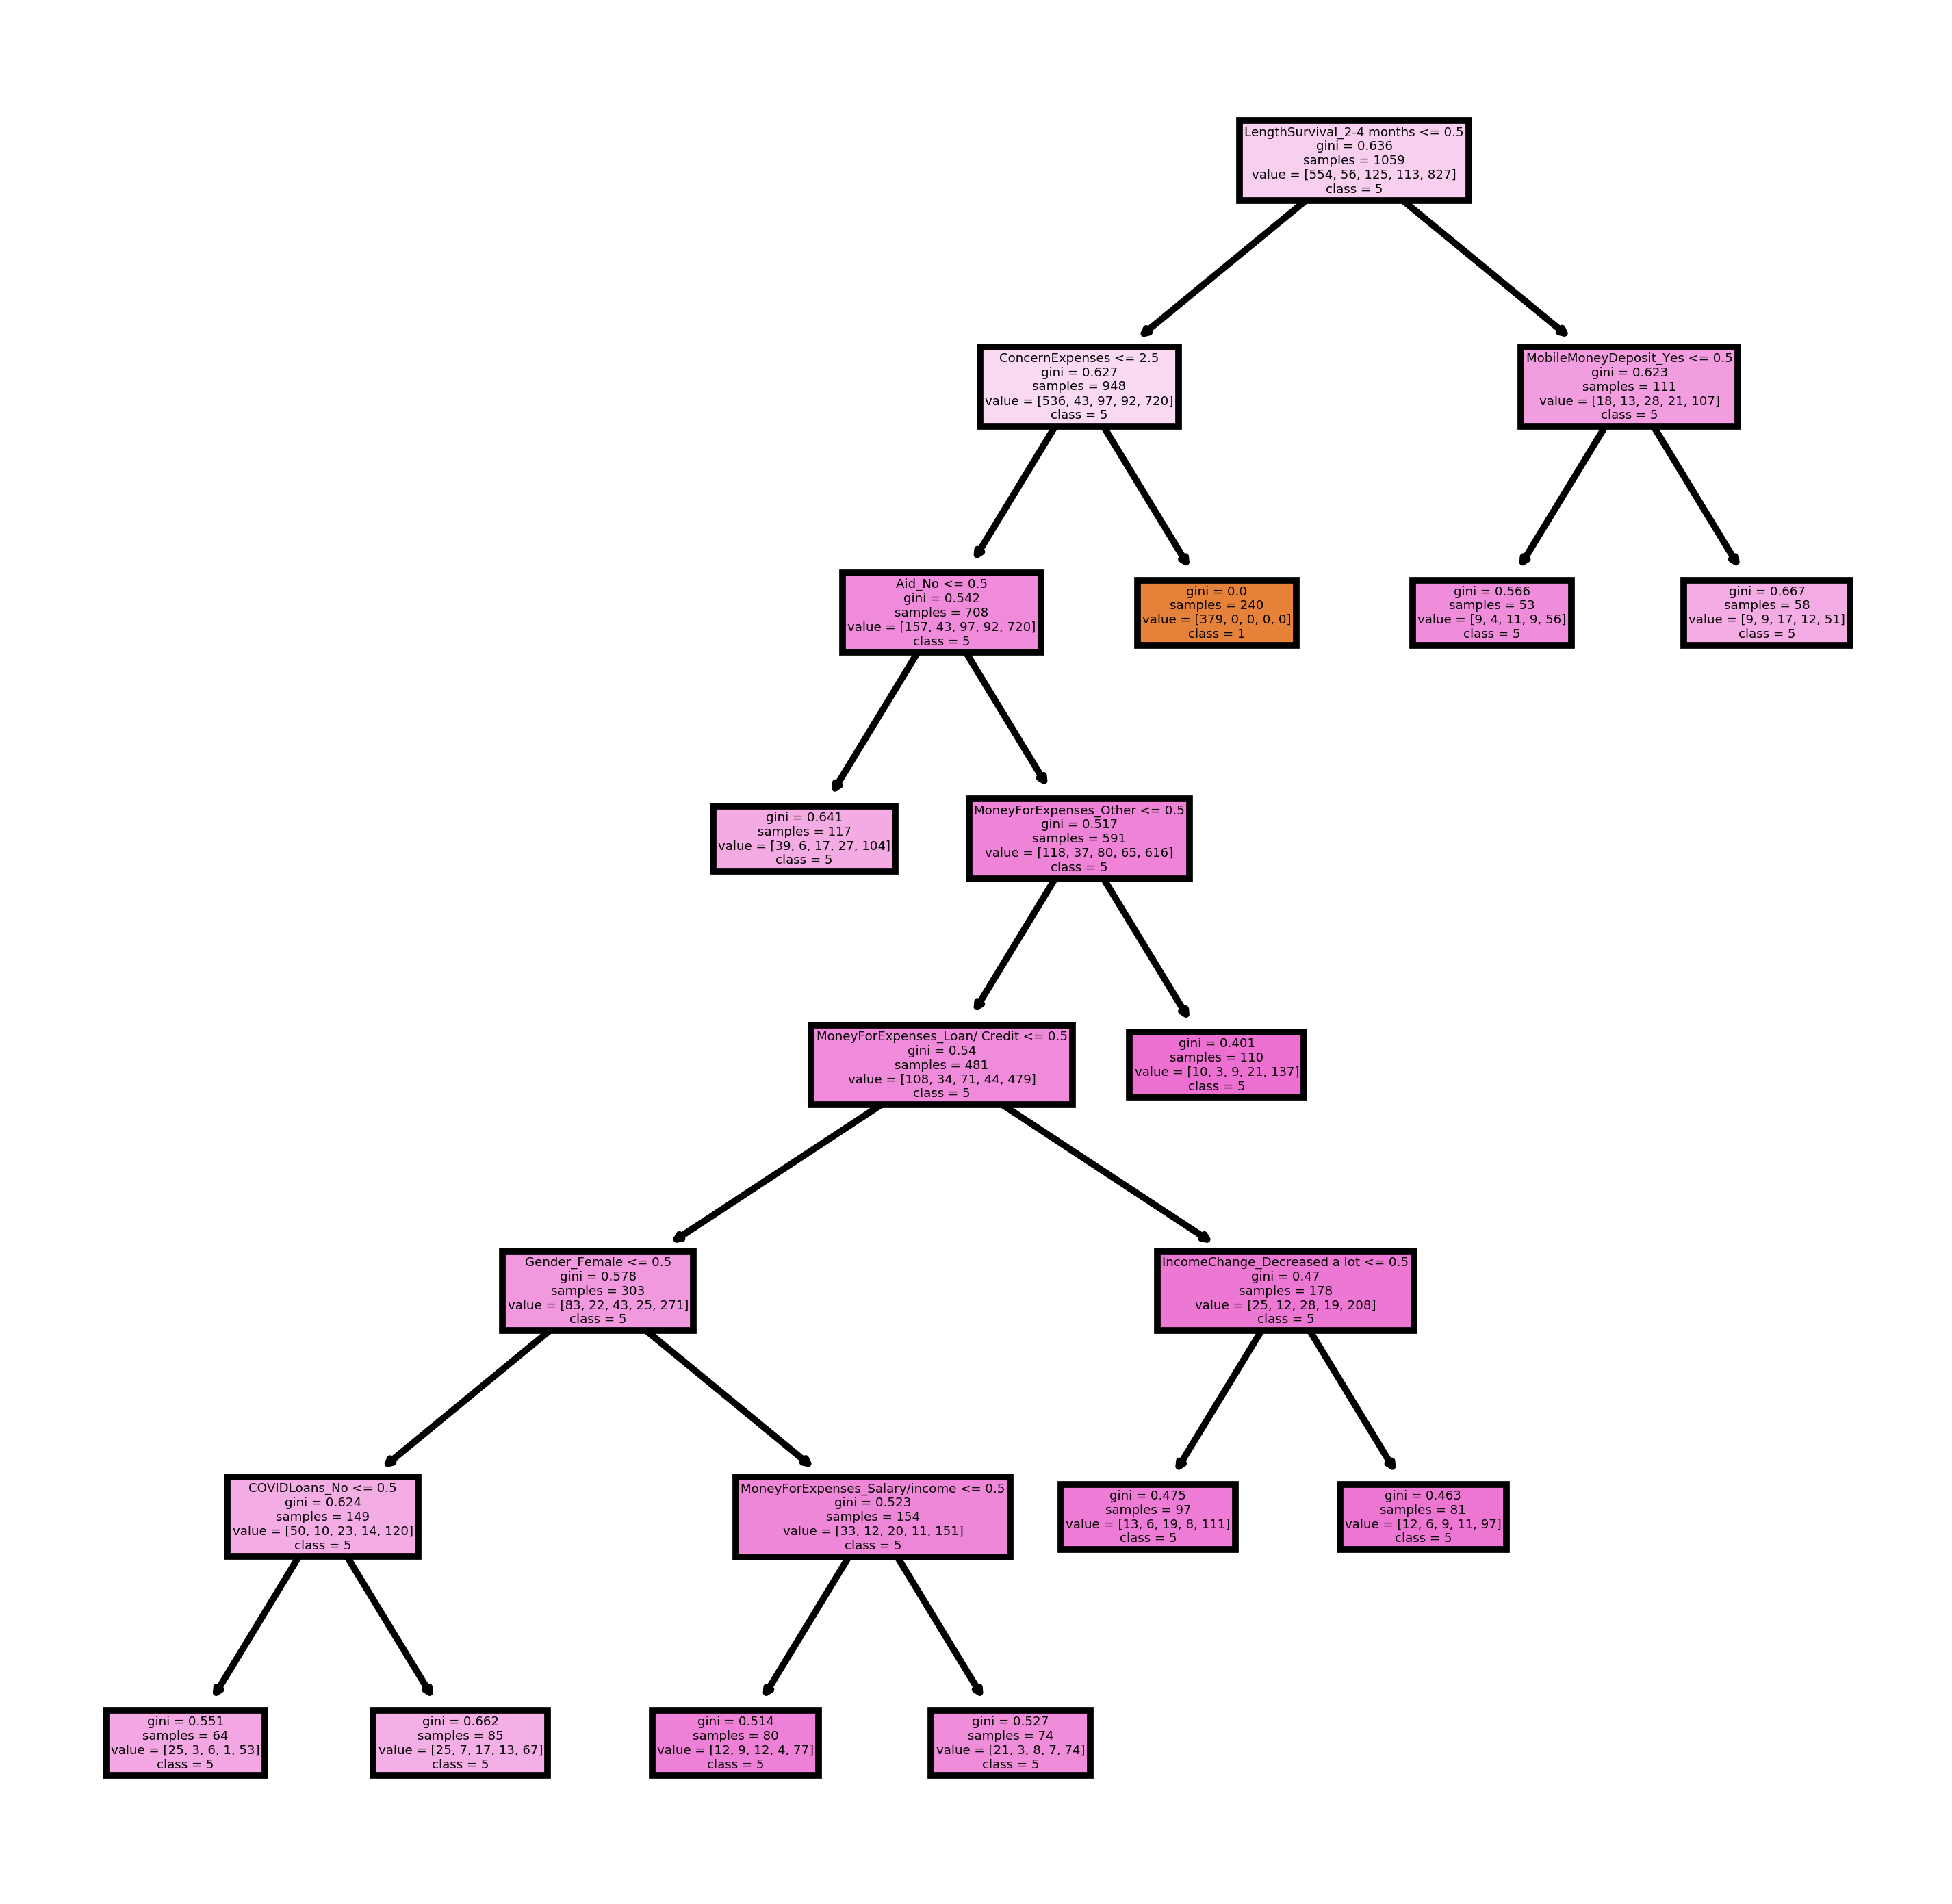

In [630]:
#Viewing 50th estimator tree
class_names = ['1','2', '3','4','5']
list_columns = list(features.columns.values)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi = 700)
tree.plot_tree(rf_classifier.estimators_[49],
               feature_names = list_columns, 
               class_names=class_names,
               filled = True);
fig.savefig('randomforestFifteethTree.png')

In [631]:
#Currently the parameters used in RandomForest Classifier
print(rf_classifier.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': True, 'random_state': 10, 'verbose': 0, 'warm_start': False}


Hyperparameter tuning of Random Forest Classifier with RandomizedSearchCV method

In [632]:
#First we will use random search training- RandomizedSearchCV method  to get an estimation of the RandomForest Tree parameters 
#Number of trees in random forest
n_estimators = [150, 600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [4, 5, 6, 7, 8, 9]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3,6,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# dictionary of parameter list for RandomForest Classifier
parameters_rfclf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#On each iteration, the algorithm will choose a difference combination of these features
#First a base model
base_rfclf = RandomForestClassifier(oob_score=True, random_state =5)
#Use Random Search model and fit our data
randomclf = RandomizedSearchCV(
                        estimator = base_rfclf,
                        param_distributions = parameters_rfclf,
                        n_iter = 100, cv = 5,
                        verbose=2, random_state=12, 
                        n_jobs = -1, scoring='accuracy',return_train_score=True)
randomclf.fit(X_train,y_train.values.ravel());


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


In [633]:
#view the best parameters from fitting the random search:
randomclf.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': True}

Random Forest Model Performance with the best estimators of hyperparameters

In [634]:
#Performance using this best_params_ 

modified_random = randomclf.best_estimator_
predictions = modified_random.predict(X_test)
print("Accuracy using Random Forest Tree with RandomizedSearchCV proces of tuning is %.3f" % metrics.accuracy_score(y_test, predictions))
confusionmatrix = pd.DataFrame(confusion_matrix(y_test, predictions),columns=class_names, index=class_names)
confusionmatrix


Accuracy using Random Forest Tree with RandomizedSearchCV proces of tuning is 0.714


1  2  3  4    5
1  204  0  0  0  100
2    0  0  0  0   34
3    0  0  0  0   61
4    0  0  0  0   41
5    0  0  0  0  385

In [635]:
#Important Features with these random forest classifier from the randomized search

featureimportance_rfclf = pd.DataFrame(modified_random.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending = False)
featureimportance_rfclf

importance
ConcernExpenses                                       0.127043
LengthSurvival_Not Applicable                         0.104572
ExpenseResponsibility_No                              0.104366
MoneyForExpenses_Not Applicable                       0.090917
ExpenseResponsibility_Yes                             0.077633
Age                                                   0.052003
MonthlyNeed                                           0.051908
LengthSurvival_< a month                              0.020690
MoneyForExpenses_Loan/ Credit                         0.019124
LengthSurvival_Donot know                             0.015534
MonthlyIncome Bracket                                 0.015273
MoneyForExpenses_Other                                0.013981
MoneyForExpenses_Savings                              0.012558
LengthSurvival_1 month                                0.012538
MobileMoneyActivity_Decreased                         0.010901
Aid_No                                                0.010619
MoneyForExpenses_Salary/income                        0.010407
Aid_Yes                                               0.010352
LengthSurvival_2-4 months                             0.010078
GovernmentPriority_Protecting people from COVID-19    0.009559
IncomeChange_Decreased a bit                          0.009476
MobileMoneyDeposit_No                                 0.009285
GovernmentPriority_Reopening the economy              0.009240
Gender_Male                                           0.009198
MobileMoneyActivity_Stayed the same                   0.009125
COVIDLoans_No                                         0.009117
COVIDLoans_Yes                                        0.008973
MobileMoneyDeposit_Yes                                0.008869
Gender_Female                                         0.008812
LengthSurvival_5+ months                              0.008776
MobileMoneyActivity_Increased                         0.008305
MobileMoneyActivity_Donot know                        0.007629
IncomeChange_Decreased a lot                          0.007440
EmploymentType_Student                                0.007414
JobRegain_Yes                                         0.006904
JobLoss_No-I’m still able to work                     0.006881
EmploymentType_Employed full time                     0.006790
IncomeChange_No change                                0.006591
EmploymentType_Self-employed                          0.006461
EmploymentType_Employed part time                     0.006303
GovernmentPriority_Not sure                           0.006195
EmploymentType_Unemployed                             0.006164
JobRegain_Not Applicable                              0.005697
JobLoss_Yes                                           0.005299
IncomeChange_Not Applicable                           0.005290
JobLoss_Not Applicable                                0.005190
JobRegain_Don't know                                  0.004938
JobLoss_Prefer not to say                             0.004466
JobRegain_No                                          0.003921
IncomeChange_Increased a bit                          0.003576
EmploymentType_Other                                  0.003476
GovernmentPriority_Other                              0.002860
IncomeChange_Increased a lot                          0.001284

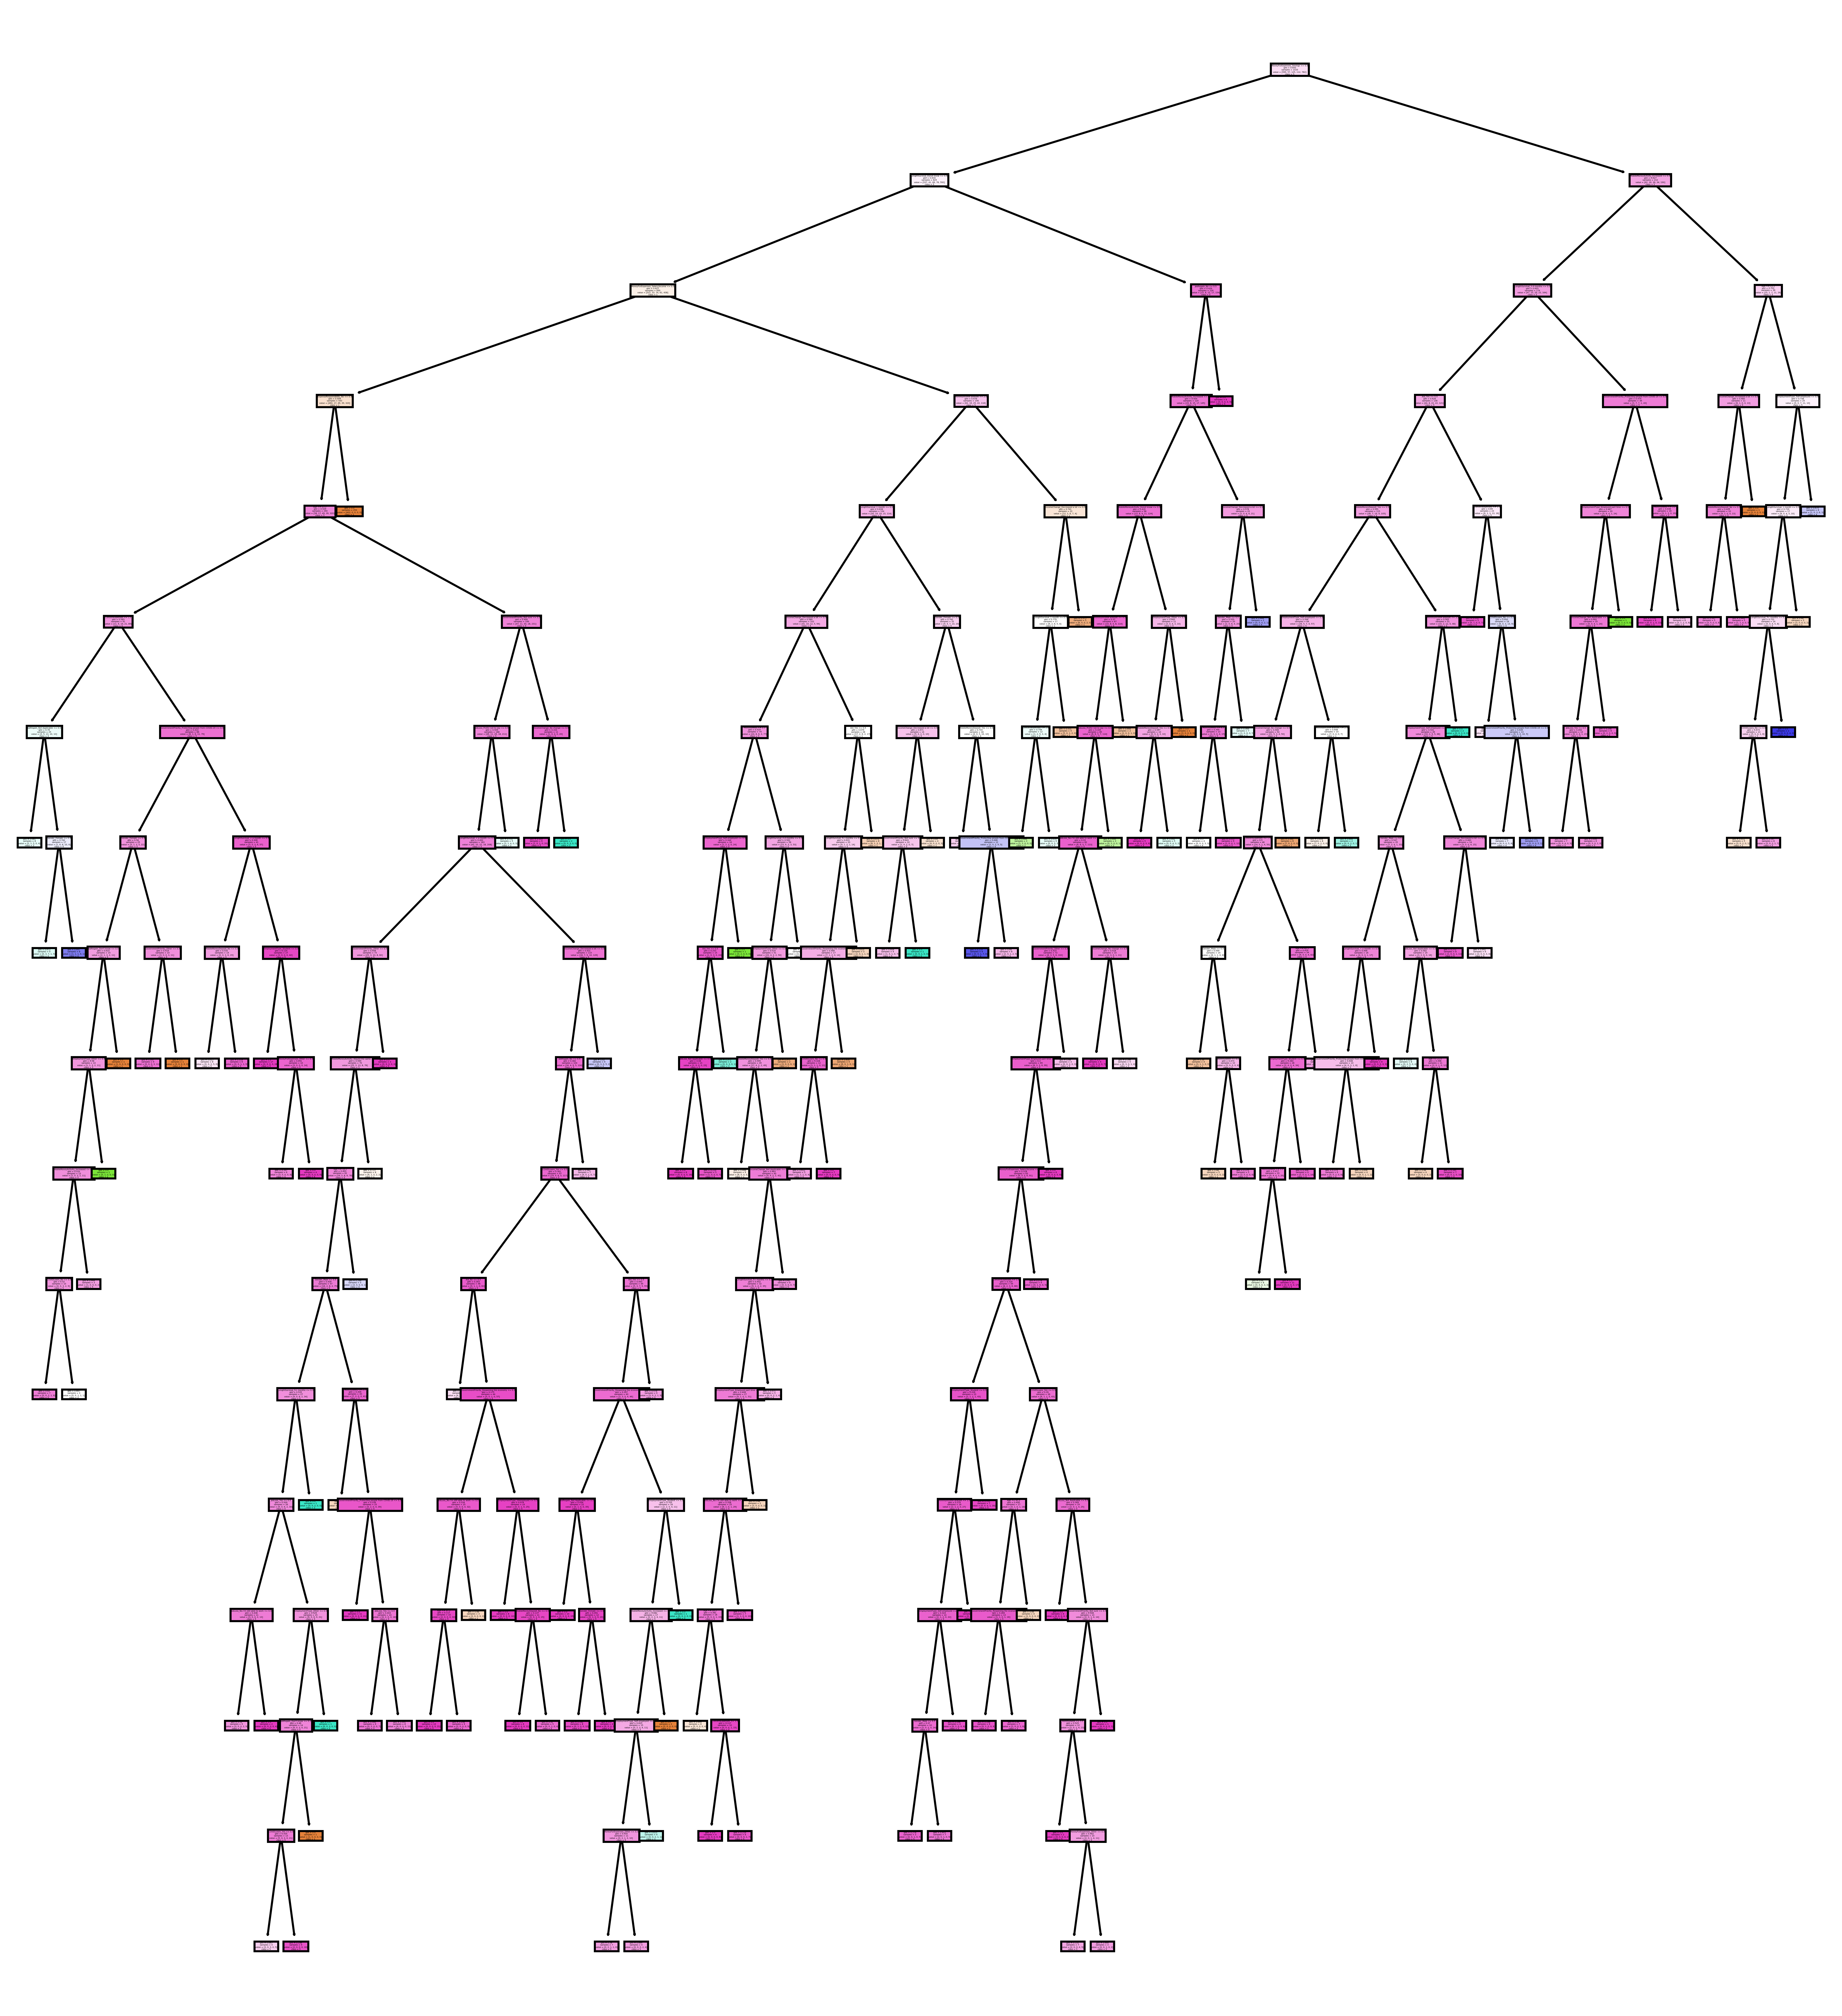

In [636]:

#Viewing 3rd estimator tree with this best estimator from randomised search classifier
class_names = ['1','2', '3','4','5']
list_columns = list(features.columns.values)
figure, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (16, 18), dpi = 500)
tree.plot_tree(modified_random.estimators_[2],
               feature_names = list_columns, 
               class_names=class_names,
               filled = True);
figure.savefig('DeicisionTreeWithRandomizedSearch.png')

Hyperparameter tuning for Random Forest with GridSearchCV method

In [637]:
#The model gives same accuracy with our initial model where we randomly put some values
#Next we will use another method gridsearchCV for parameters estimation

#Creating new list of parameters
seed = 4
gridsearch_parameterrf = { 
    'n_estimators': [150, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, None],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True]
}

#create basic model first

gridrfc=RandomForestClassifier(random_state=2)
#calling GridSearchCv on this base model
gridrfc_modified = GridSearchCV(estimator=gridrfc, param_grid=gridsearch_parameterrf, cv= 5, n_jobs = -1, verbose = 3,scoring='accuracy',return_train_score=True)
gridrfc_modified.fit(X_train, y_train.values.ravel())



Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=2,
                                   

In [638]:
gridrfc_modified.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 150}

In [639]:
#Fit the best parameters on RandomForestClassifier

modified_gridsearchrfc = RandomForestClassifier(random_state=5, max_features='auto', n_estimators= 150, max_depth=6, criterion='gini',bootstrap=True)
modified_gridsearchrfc.fit(X_train, y_train.values.ravel())
gridsearch_predictions = modified_gridsearchrfc.predict(X_test)
print("Accuracy by using the Best Parameters from GridSearchCV %.3f" % metrics.accuracy_score(y_test, gridsearch_predictions))


Accuracy by using the Best Parameters from GridSearchCV 0.712


Preview one of the estimator tree of Random Forest

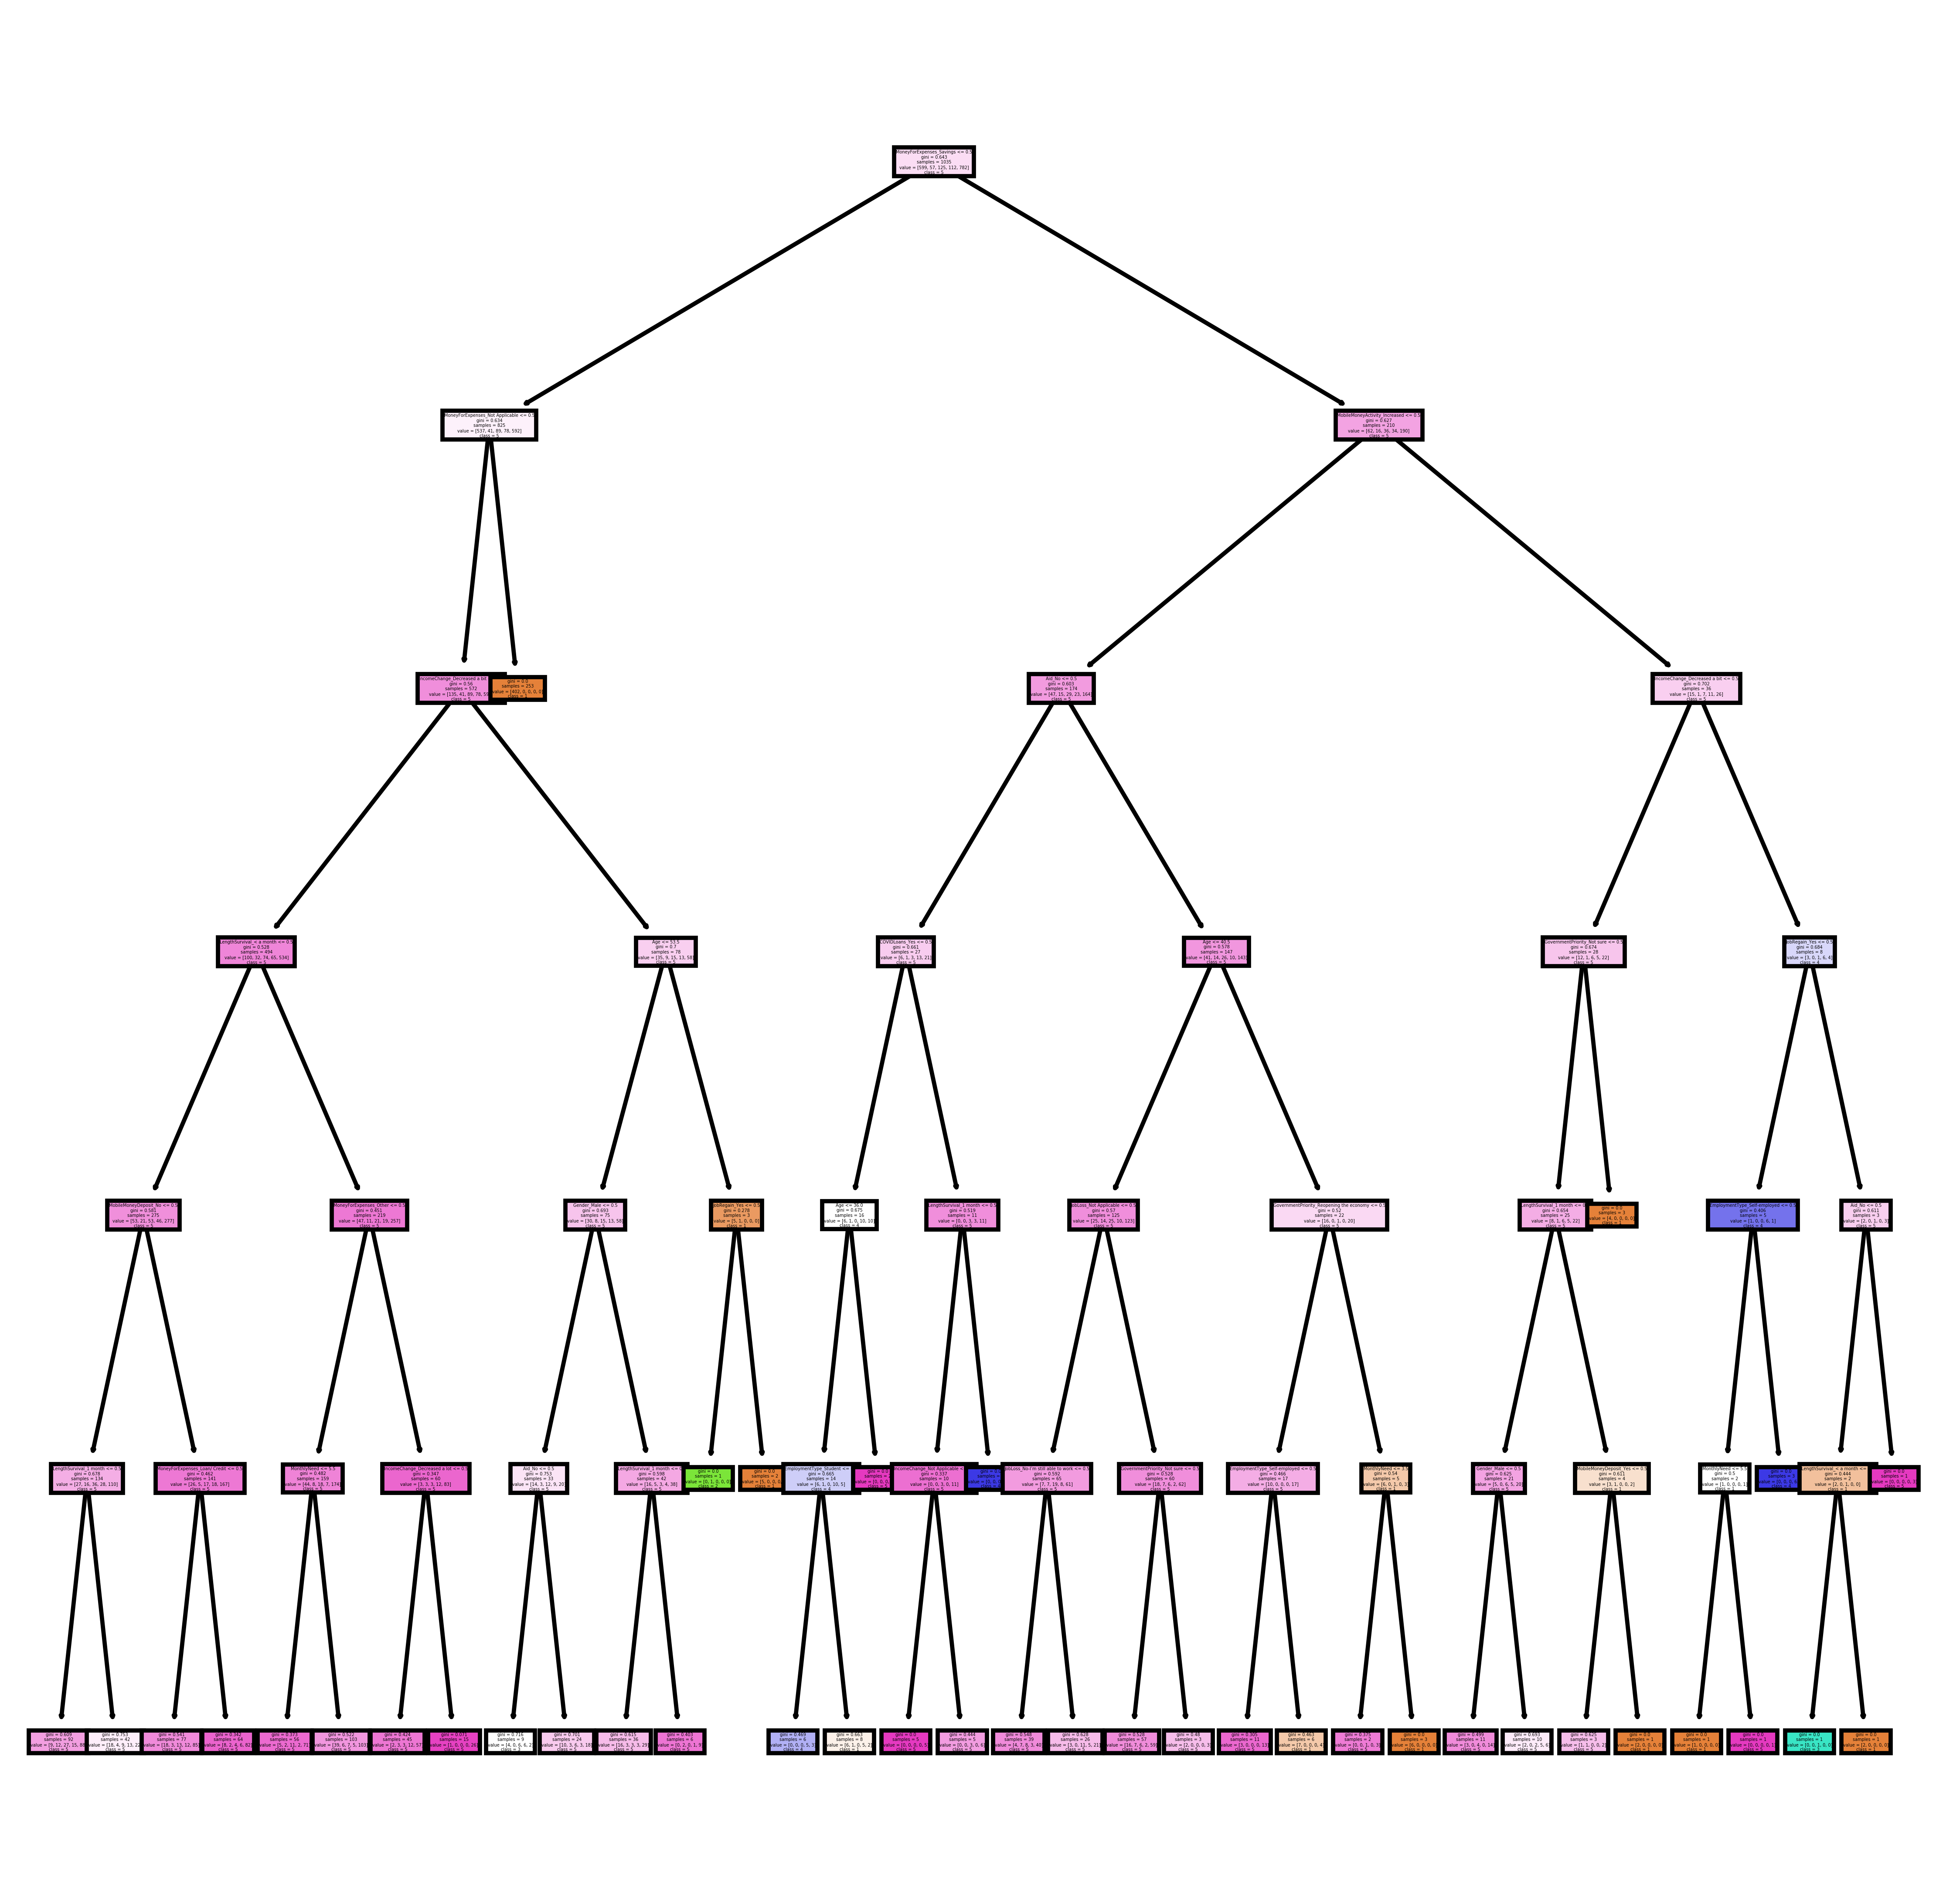

In [640]:
#As we can see, still it is not that much improvement from our previous two models.
#Viewing 3rd estimator tree
class_names = ['1','2', '3','4','5']
list_columns = list(features.columns.values)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi = 700)
tree.plot_tree(modified_gridsearchrfc.estimators_[2],
               feature_names = list_columns, 
               class_names=class_names,
               filled = True);
fig.savefig('RandomForestGridSearchTree.png')

#### Naive Bayes Classifier ####

In [641]:


######### Moving to Naive Bayes Classifier##########################
##We start with Gaussian Classifier 
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
ytest_predict = gnb.predict(X_test)
print("Accuracy with Gaussian Naive Bayes Classifier %.3f" % metrics.accuracy_score(y_test, ytest_predict))



    

Accuracy with Gaussian Naive Bayes Classifier 0.422


The possible reason with this low accuracy score is that in our dataset , we have lot of categorical variables which we have encoded by one-hot encoding process.Now Gaussian Naive Bayes models these by following a normal distribution. But in our dataset , as we know that most of the categorical variables will be encoded as zeroes and ones, so that may be the reason that we are not capturing the useful information in model.This may not be a good choice of model.

#### Logistic Multiclass Classifier ####

In [642]:
#Logistic Regression Multiclass classification with using one vs rest
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
train_tranformed = scaler.transform(X_train)
test_tranformed= scaler.transform(X_test)
#Logistic Regression Multiclass using ovr as parameter
logRmodel = LogisticRegression(solver = 'lbfgs', multi_class='ovr')
logRmodel.fit(train_tranformed, y_train.values.ravel())
# use the model to make predictions with the test data
logRmodel_pred = logRmodel.predict(test_tranformed)
# model performance
logRmodel_accuracy = metrics.accuracy_score(y_test, logRmodel_pred)
print('Logistic Multiclass Model Accuracy: {:.2f}'.format(logRmodel_accuracy))
misclassified_number = (y_test.values.ravel() != logRmodel_pred).sum()
print('Number of samples which are Misclassified: {}'.format(misclassified_number))

Logistic Multiclass Model Accuracy: 0.71
Number of samples which are Misclassified: 238


              precision    recall  f1-score   support

     class 1       0.96      0.69      0.80       304
     class 2       0.00      0.00      0.00        34
     class 3       0.17      0.03      0.05        61
     class 4       0.00      0.00      0.00        41
     class 5       0.63      0.98      0.77       385

    accuracy                           0.71       825
   macro avg       0.35      0.34      0.32       825
weighted avg       0.66      0.71      0.66       825



Text(69.0, 0.5, 'Truth')

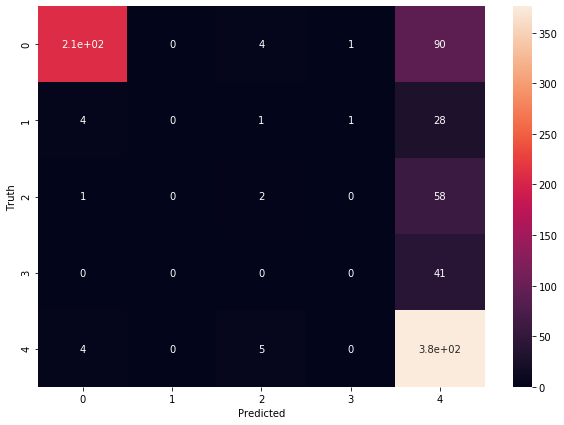

In [643]:
targetclass_names = ['class 1', 'class 2', 'class 3','class 4', 'class 5' ]

print(classification_report(y_test, logRmodel_pred, target_names= targetclass_names,zero_division = 0))

cm = confusion_matrix(y_test,logRmodel_pred)
plt.figure(figsize= (10,7))
sns.heatmap(cm, annot = True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

As we have observed so far that Random Forest Classifier provides the best accuracy score so we will keep that as our reference model and erfor feature selction on Random Forest now.

####  Feature Selection with SelectModel for Random Forest classifier ####

In [644]:
from sklearn.feature_selection import SelectFromModel

#n_estimators': 600,
#'min_samples_split': 10,
#'min_samples_leaf': 1,
#'max_features': 'log2',
#'max_depth': None,
#'bootstrap': True}


# selector object that will use the random forest classifier to identify
# features that have an importance of greater than the mean importance of alll features will be selected

clfmodel = RandomForestClassifier(n_estimators = 600, random_state = 3,min_samples_split =10,bootstrap =True )
clfmodel.fit(X_train, y_train.values.ravel())
clfmodel_selected = SelectFromModel(clfmodel)
#Training the selecter
clfmodel_selected.fit(X_train, y_train.values.ravel())


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=10,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=600, n_jobs=None,
                                                 oob_score=False

Features selected by SelectFromModel method for Random Forest Classifier

In [645]:
features_selected = X_train.columns[(clfmodel_selected.get_support())]
features_selected

Index(['Age', 'ConcernExpenses', 'MonthlyNeed', 'ExpenseResponsibility_No',
       'ExpenseResponsibility_Yes', 'LengthSurvival_Not Applicable',
       'MoneyForExpenses_Not Applicable'],
      dtype='object')

Train new Random Forest clasifier with the selected features only

In [646]:
#Selecting only these important features and transfor the training and test set 
Xtrain_new = clfmodel_selected.transform(X_train)
Xtest_new = clfmodel_selected.transform(X_test)
#new randomforest classifier with these important features and the best estimated hyperparameters from randomizedSearch
rfclf_final = RandomForestClassifier(n_estimators=600,n_jobs=-1, random_state = 4,min_samples_split =10,bootstrap =True )                                       
#Training this new classifier with updated data having the features which are important
rfclf_final.fit(Xtrain_new,y_train.values.ravel())                                        

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)

In [647]:
final_ypred = rfclf_final.predict(Xtest_new)
# Accuaracy with the model having only the important features
print("Accuracy of RandomForest Classifier wwith features selected by SelectModel method: {:.3f}".format(metrics.accuracy_score(y_test, final_ypred)))


Accuracy of RandomForest Classifier wwith features selected by SelectModel method: 0.687


We have the model now with reduced feature dimensionality in the expense of the accuracy score from 0.715 to 0.68

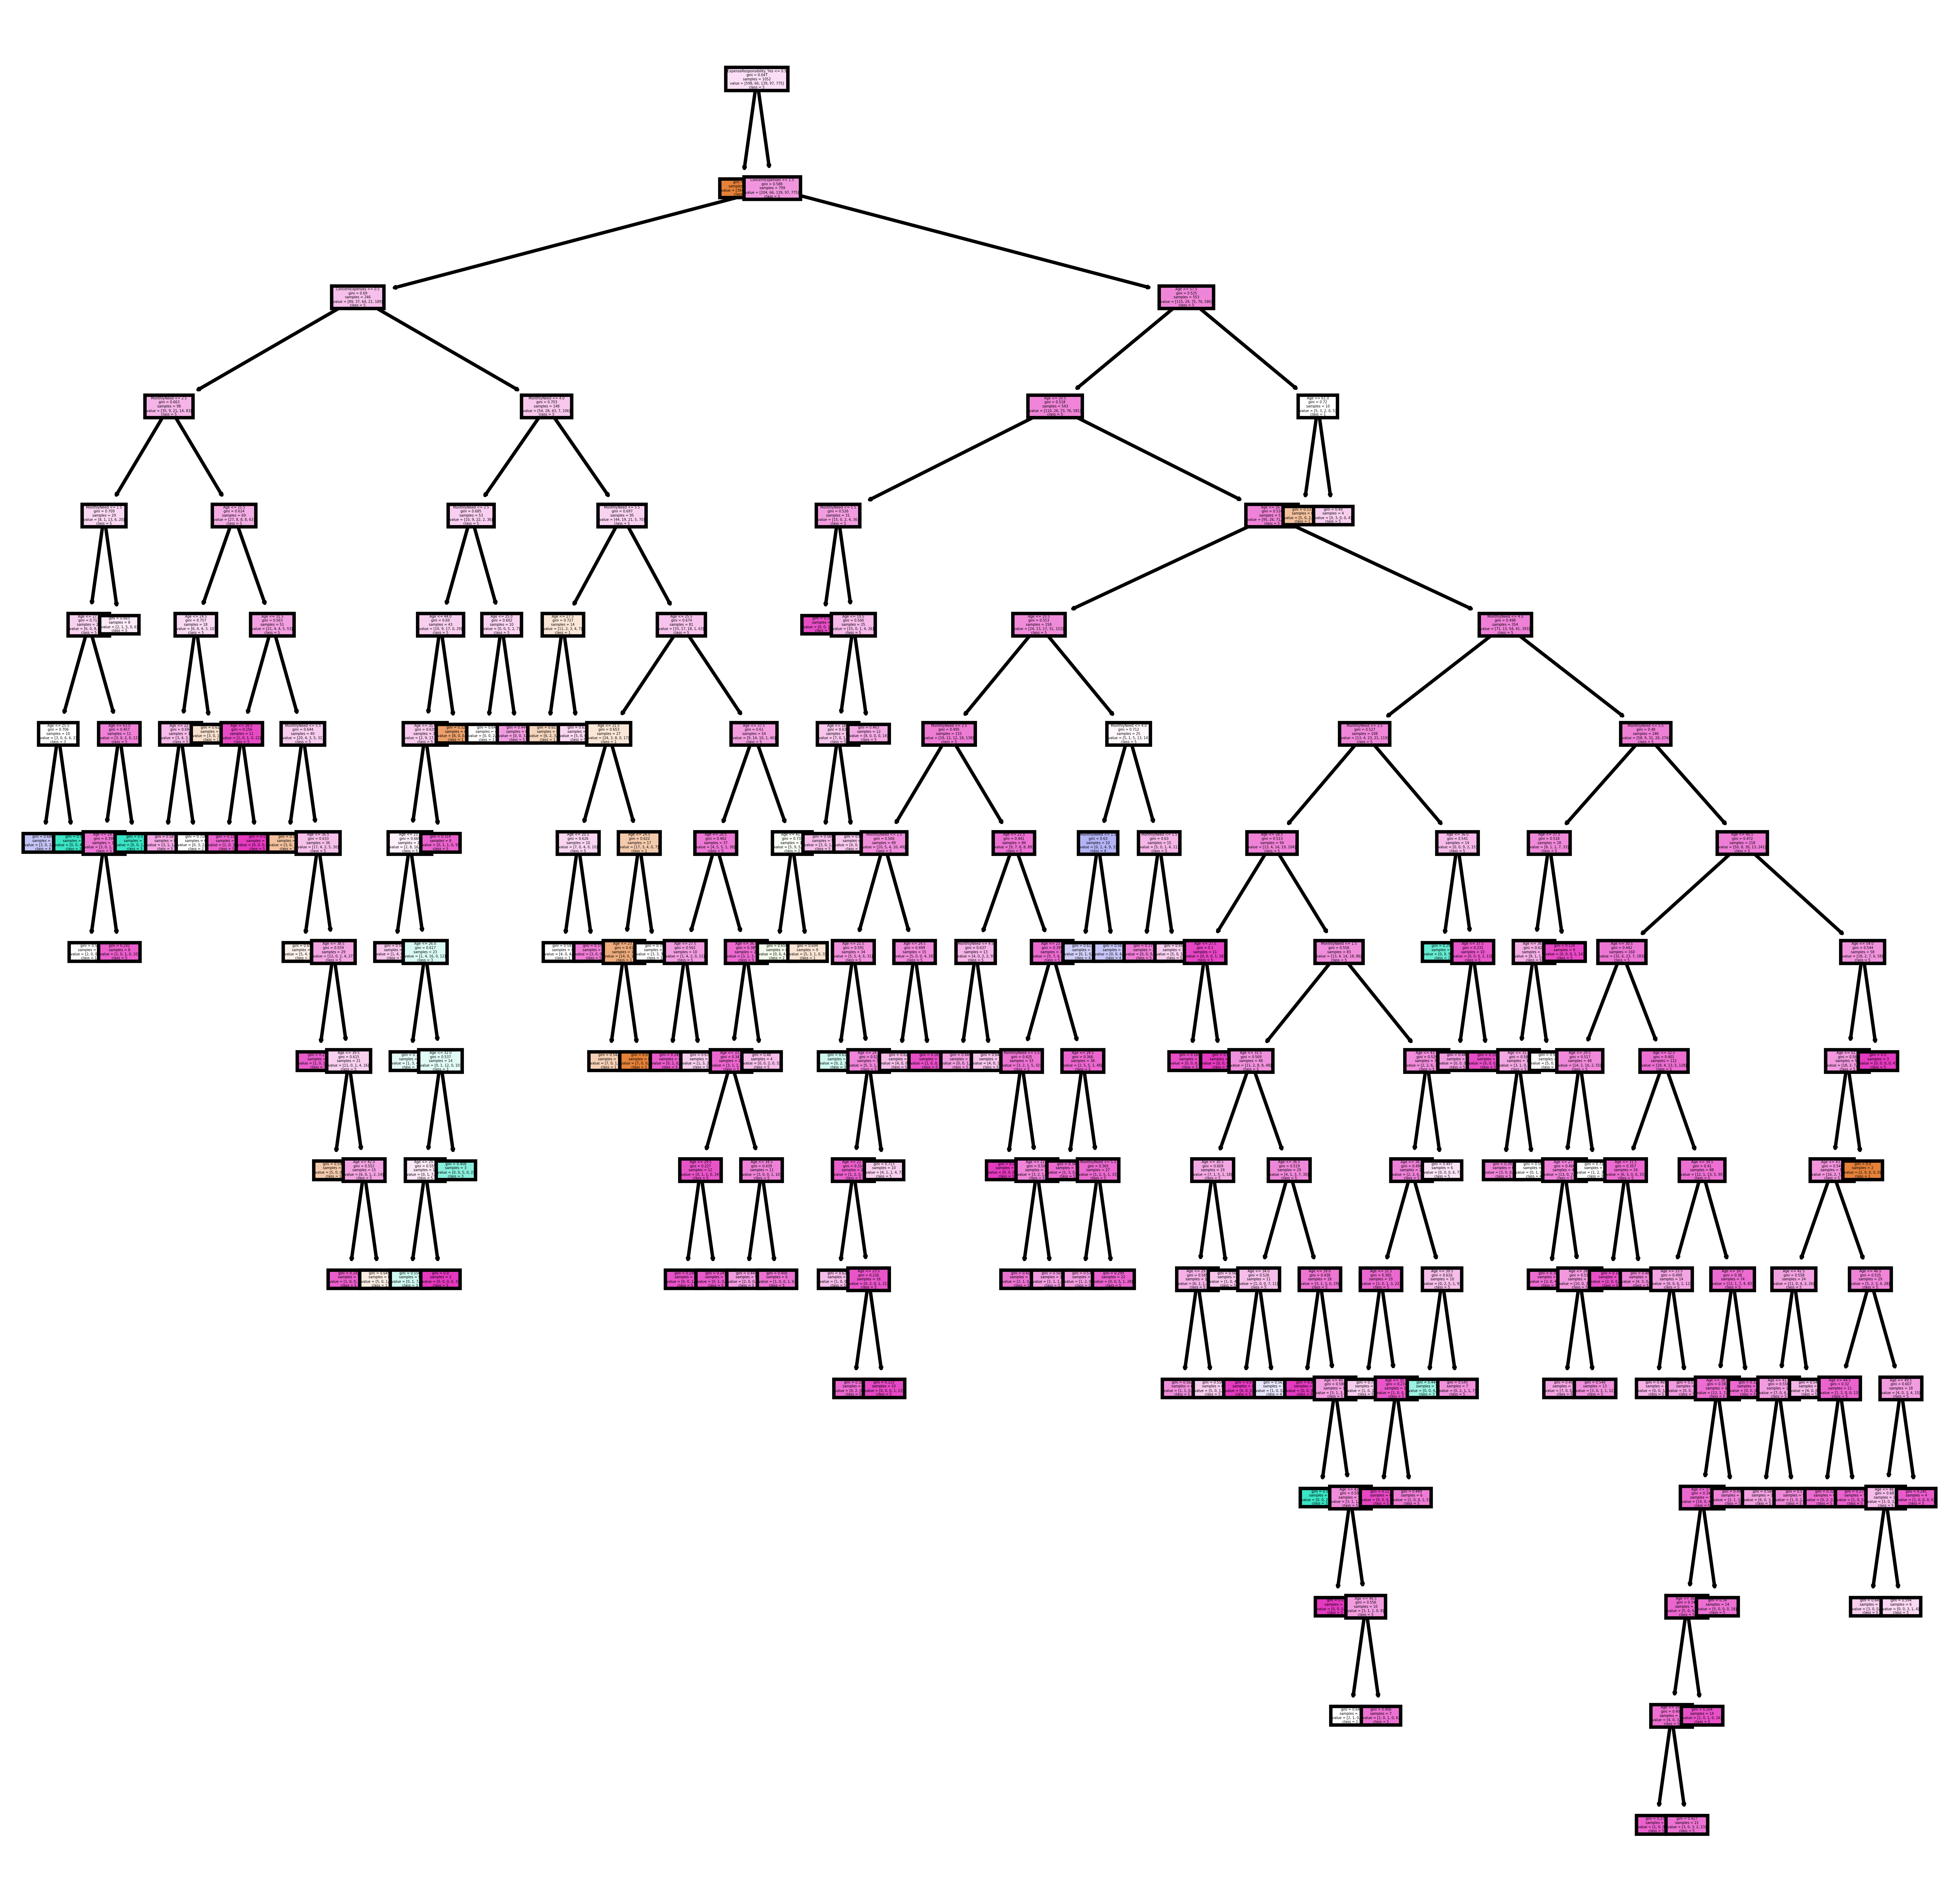

In [648]:
#Viewing 3rd estimator tree
class_names = ['1','2', '3','4','5']
reducedfeatures = ['Age', 'ConcernExpenses', 'MonthlyNeed', 'ExpenseResponsibility_No',
       'ExpenseResponsibility_Yes', 'LengthSurvival_Not Applicable',
       'MoneyForExpenses_Not Applicable']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi = 700)
tree.plot_tree(rfclf_final.estimators_[2],
               feature_names = reducedfeatures, 
               class_names=class_names,
               filled = True);
fig.savefig('RandomForestTree with Reduced Features.png')

#### Feature Selection of Random Forest Classifier by RFE Method ####

In [649]:
from sklearn.feature_selection import RFE
rfe = RFE(RandomForestClassifier(n_estimators=600,n_jobs=-1, random_state = 6,min_samples_split =10,bootstrap =True),n_features_to_select = 12)
rfe.fit(X_train, y_train.values.ravel())


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=10,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=600, n_jobs=-1,
                                     oob_score=False, random_state=6, verbose=0,
                                     warm_start=False),
    n_features_to_select=12, step=1, verbose=0)

Features selected by RFE method for Random Forest

In [650]:
selectedfeature_RFE = X_train.columns[(rfe.get_support())]
selectedfeature_RFE

Index(['Age', 'MonthlyIncome Bracket', 'ConcernExpenses', 'MonthlyNeed',
       'ExpenseResponsibility_No', 'ExpenseResponsibility_Yes',
       'LengthSurvival_< a month', 'LengthSurvival_Not Applicable',
       'MoneyForExpenses_Loan/ Credit', 'MoneyForExpenses_Not Applicable',
       'Aid_No', 'MobileMoneyDeposit_No'],
      dtype='object')

Train new Random Forest Classifier with the selected features by RFE

In [651]:
#New subset with the features selected by RFE -Recursive Feature Elimination method
X_train_rfeselected = rfe.transform(X_train)
X_test_rfselected = rfe.transform(X_test)

randomforest_rfe = RandomForestClassifier(n_estimators=600,n_jobs=-1, random_state =1,min_samples_split =10,bootstrap =True )                                       
#Training this new classifier with updated data having the features which are important by RFE method
randomforest_rfe.fit(X_train_rfeselected,y_train.values.ravel()) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Accuracy Score with the new Random Forest Classifier with selected features by RFE 

In [652]:
ypred_rfe_clf = randomforest_rfe.predict(X_test_rfselected)
# Accuaracy with the model having only the important features
print("Accuracy of RandomForest Classifier with features selected by Recursive Feature Elimination : {:.3f}".format(metrics.accuracy_score(y_test, ypred_rfe_clf)))


Accuracy of RandomForest Classifier with features selected by Recursive Feature Elimination : 0.701


Here we have achived 70% accuracy score with the 12 features only .

In [653]:
targetclass_names = ['class 1', 'class 2', 'class 3','class 4', 'class 5' ]

print(classification_report(y_test, ypred_rfe_clf, target_names= targetclass_names,zero_division = 0))

cm = confusion_matrix(y_test,ypred_rfe_clf)
cm

              precision    recall  f1-score   support

     class 1       0.95      0.67      0.79       304
     class 2       0.00      0.00      0.00        34
     class 3       0.20      0.03      0.06        61
     class 4       0.00      0.00      0.00        41
     class 5       0.62      0.96      0.75       385

    accuracy                           0.70       825
   macro avg       0.35      0.33      0.32       825
weighted avg       0.65      0.70      0.65       825



array([[205,   0,   2,   0,  97],
       [  0,   0,   1,   0,  33],
       [  1,   0,   2,   0,  58],
       [  1,   0,   0,   0,  40],
       [  9,   0,   5,   0, 371]], dtype=int64)